<a href="https://colab.research.google.com/github/claudiobarril/aprendizaje_profundo/blob/main/Deep_Learning_TP_Cohorte_17_5B2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Universidad de Buenos Aires
# Deep Learning - TP
# Cohorte 17 - 5to bimestre 2024


El TP comienza al momento de recibir este correo y la ventana de entrega estará abierta hasta **las 20hs del Lunes 03 de diciembre**. La resolución es individual. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citadas incluyendo el correspondiente link o página de libro.

El formato de entrega debe ser un “link a un colab” (permitir acceso a las siguientes direcciones: alfonsorafel93@gmail.com y lelectronfou@gmail.com) y **se realizará en el siguiente link de google form: [link](https://docs.google.com/forms/d/e/1FAIpQLScnAC5wu1fIOqDKGrbdV8MZfU6AlJ6B7tBNNpL3qRAEGaudzg/viewform?usp=sf_link)**. Tanto los resultados, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

NO ES NECESARIO QUE NOS ENVIEN COREEO AVISANDO DE LA ENTREGA!

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para la totalidad del examen.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-TP Co(numero de cohorte).ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código y las explicaciones deben quedar guardados y visualizables en el correspondiente link.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.


**Condiciones de aprobación**
- Se aprueba con más del 60% del examen bien resuelto de cada parte del TP (Parte 1 y Parte 2).
- La escala de notas empleada por la UBA es aprobado para nota igual o superior a 4.

# Parte 1
Descargar el dataset del siguiente link: https://drive.google.com/file/d/1X8_G5BpQMi-Nnbtms2RL8lcWSxzD8ixd/view?usp=sharing. El dataset son compras de productos que diferentes clientes realizaron durante un black sales. El dataset contiene información sobre las transacciones y el objetivo es poder utilizarlo para crear diferentes modelos que puedan predecir cuánto un cliente está dispuesto a gastar en un producto en el futuro.
- a) Praparacion del dataset: procesar las variables, explicar los criterios utilizados y analizar las distribuciones.

Particularmente para los puntos b), c) y d) vamos a tratar este problema como una clasificación donde queremos averiguar si el cliente pertenece al grupo 0 (gasta menos de 5000), al grupo 1 (gasta entre 5000 y 10000), al grupo 2 (gasta entre 10000 y 15000) o al grupo 3 (gasta más de 15000).
- b) Definir uno o varios puntos de comparacion (benchmark) para comparar los modelos. Pueden usarse modelos de ML clasico de facil entrenamiento.
- c) Entrenar un modelo de deep learning que no utilice embeddings, **descartando el `product_id` y `user_id`.** . Graficar las evoluciones de la funcion de costo y la metrica de validacion. Explicar el proceso de iteracion utilizado para conseguir los resultados y justificar los resultados obtenidos.
- d)	Entrenar un modelo de deep learning que utilice **2 capas de embeddings**, una para los productos y otra para los usuarios. Graficar las evoluciones de la funcion de costo y la metrica de validacion. Explicar el proceso de iteracion utilizado para conseguir los resultados y justificar los resultados obtenidos. Comparar contra el modelo sin embeddings.
Recordar que tanto para el punto c) como el d) pueden usarse herramientas como regularizacion y prueba de hiperpametros para conseguir mejores resultados.
- e) Para el modelo del punto c) implementar una funcion que a reciba un id de usuario y sugiera **n** cantidad usuarios que tuvieron un comportamiento de compras similar.
- f) Para el mejor modelo obtenido en el apartado d) elegir al menos 2 hiperparametros para tunear. Explicar el metodo utilizado y los resultados obtenidos. Recordar de explicar los criterios de eleccion de los hiperpametros, no elegirlos al azar.



#Parte 1 - Resolución



Empezamos importando las librerías que utilizaremos a lo largo de esta sección:

In [1]:
!pip install catboost
!pip install gdown
!pip install optuna

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import catboost
import copy
import torch.nn.functional as F
import optuna

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_auc_score, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
from torch.nn.functional import one_hot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.7 MB/s eta 0:00:00


## Preparación del dataset (a) ##


Cargamos el archivo para su análisis:

In [3]:
file_id = "1X8_G5BpQMi-Nnbtms2RL8lcWSxzD8ixd"
url = f"https://drive.google.com/uc?id={file_id}"
output_path = "dataset_black_sales.csv"
!gdown {url} -O {output_path}

black_sale_data = pd.read_csv(output_path)

Downloading...
From: https://drive.google.com/uc?id=1X8_G5BpQMi-Nnbtms2RL8lcWSxzD8ixd
To: /content/dataset_black_sales.csv
100% 25.5M/25.5M [00:00<00:00, 67.4MB/s]


### Visualización ###

Empecemos viendo cantidad de observaciones, features, total de duplicados, información de las features, algunas observaciones de ejemplo, y cardinalidad o incluso los distintos valores que podemos encontrar en algunas de las features:

In [ ]:
shape = black_sale_data.shape
print(f'[{shape[0]}]observaciones - [{shape[1]}]features')
duplicados = black_sale_data.duplicated().sum()
print(f'Total de duplicadas: {duplicados}')
black_sale_data.describe(include='all').T

[550068]observaciones - [12]features
Total de duplicadas: 0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
User_ID,550068.0,NaN,NaN,NaN,1003028.842401,1727.591586,1000001.0,1001516.0,1003077.0,1004478.0,1006040.0
Product_ID,550068,3631,P00265242,1880,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,550068,2,M,414259,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,550068,7,26-35,219587,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,550068.0,NaN,NaN,NaN,8.076707,6.52266,0.0,2.0,7.0,14.0,20.0
City_Category,550068,3,B,231173,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stay_In_Current_City_Years,550068,5,1,193821,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital_Status,550068.0,NaN,NaN,NaN,0.409653,0.49177,0.0,0.0,0.0,1.0,1.0
Product_Category_1,550068.0,NaN,NaN,NaN,5.40427,3.936211,1.0,1.0,5.0,8.0,20.0
Product_Category_2,376430.0,NaN,NaN,NaN,9.842329,5.08659,2.0,5.0,9.0,15.0,18.0


In [ ]:
black_sale_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [ ]:
black_sale_data.sample(5)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
127173,1001606,P00240042,F,36-45,3,A,4+,0,5,NaN,NaN,8803
50353,1001697,P00025542,F,18-25,4,B,3,0,8,NaN,NaN,9982
387745,1005664,P00304642,M,18-25,4,C,4+,0,2,14.0,15.0,9675
172293,1002645,P00028542,M,26-35,7,A,1,0,6,8.0,14.0,20245
35600,1005498,P00255942,F,51-55,1,C,3,1,1,16.0,NaN,8267


In [ ]:
for col in black_sale_data.columns:
  print(f'{col}: {black_sale_data[col].nunique()}')

User_ID: 5891
Product_ID: 3631
Gender: 2
Age: 7
Occupation: 21
City_Category: 3
Stay_In_Current_City_Years: 5
Marital_Status: 2
Product_Category_1: 20
Product_Category_2: 17
Product_Category_3: 15
Purchase: 18105


In [ ]:
columns_to_check = ['Gender', 'Age', 'Occupation', 'City_Category',
                    'Stay_In_Current_City_Years', 'Marital_Status',
                    'Product_Category_1', 'Product_Category_2', 'Product_Category_3']

for col in columns_to_check:
  print(f"Distinct values for {col}: {black_sale_data[col].unique()}")

Distinct values for Gender: ['F' 'M']
Distinct values for Age: ['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25']
Distinct values for Occupation: [10 16 15  7 20  9  1 12 17  0  3  4 11  8 19  2 18  5 14 13  6]
Distinct values for City_Category: ['A' 'C' 'B']
Distinct values for Stay_In_Current_City_Years: ['2' '4+' '3' '1' '0']
Distinct values for Marital_Status: [0 1]
Distinct values for Product_Category_1: [ 3  1 12  8  5  4  2  6 14 11 13 15  7 16 18 10 17  9 20 19]
Distinct values for Product_Category_2: [nan  6. 14.  2.  8. 15. 16. 11.  5.  3.  4. 12.  9. 10. 17. 13.  7. 18.]
Distinct values for Product_Category_3: [nan 14. 17.  5.  4. 16. 15.  8.  9. 13.  6. 12.  3. 18. 11. 10.]


In [ ]:
nan_counts_product_category_2 = black_sale_data['Product_Category_2'].isna().sum()
nan_counts_product_category_3 = black_sale_data['Product_Category_3'].isna().sum()

print(f"Cantidad de NaN en Product_Category_2: {nan_counts_product_category_2}")
print(f"Cantidad de NaN en Product_Category_3: {nan_counts_product_category_3}")

Cantidad de NaN en Product_Category_2: 173638
Cantidad de NaN en Product_Category_3: 383247


#### Tipos de datos:

- **Variables categóricas**: `User_ID`, `Product_ID`, `Gender`, `Age`, `Occupation`, `City_Category`, `Stay_In_Current_City_Years`, `Marital_Status`, `Product_Category_1`, `Product_Category_2`, `Product_Category_3`
- **Variables numéricas**: `Purchase`.

#### Análisis de los datos:

- Contamos con 550068 observaciones y 12 variables.
- `User_ID` y `Product_ID` tienen muy alta cardinalidad (5891 y 3631 valores únicos respectivamente).
- `Age` cuenta con rangos de edades del comprador como categorías. No todos los rangos incluyen misma cantidad de edades.
- `Product_Category_1`, `Product_Category_2`, `Product_Category_3`, aunque numéricas, representan categorías que han sido representadas como enteros. Tenemos missings para `Product_Category_2` y `Product_Category_3`. Vamos a profundizar más en las variables `Product_Category_N` luego de analizar sus datos, para sacar mejores conclusiones.
- Desconocemos a priori el significado de los valores `Occupation`, `City_Category` y `Marital_Status`.


Veamos si podemos identificar el significado de los valores 0 y 1 para `Marital_Status`, relacionando dicha variable con la edad:

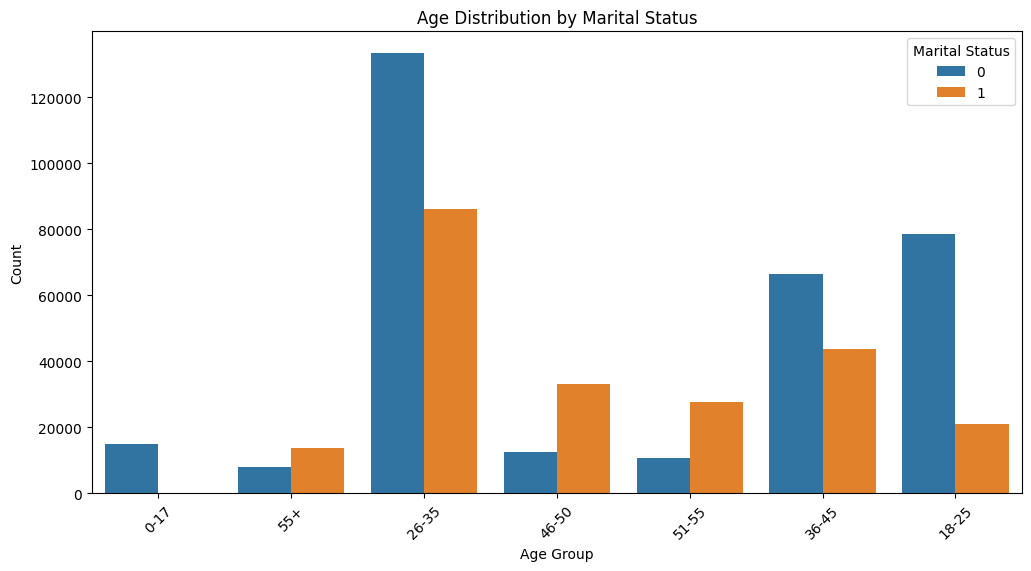

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Age', hue='Marital_Status', data=black_sale_data)
plt.title('Age Distribution by Marital Status')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Marital Status')
plt.show()

Por las distribuciones podemos asumir que `Marital_Status` es **0** para solteros (todos los menores de 17 años son de caterogría **0**, y la gran mayoría entre 18 y 25 años) y **1** para casados, a sabiendas que quedan otros posibles significados afuera.

Para entender un poco mejor las features de `Product_Category_N` vamos a ver un poco la distribución de precios de las ventas según estas variables. La idea es buscar una relación entre el hecho de tener un valor determinado en `Product_Category_1` y ese mismo valor en otra de las columnas:

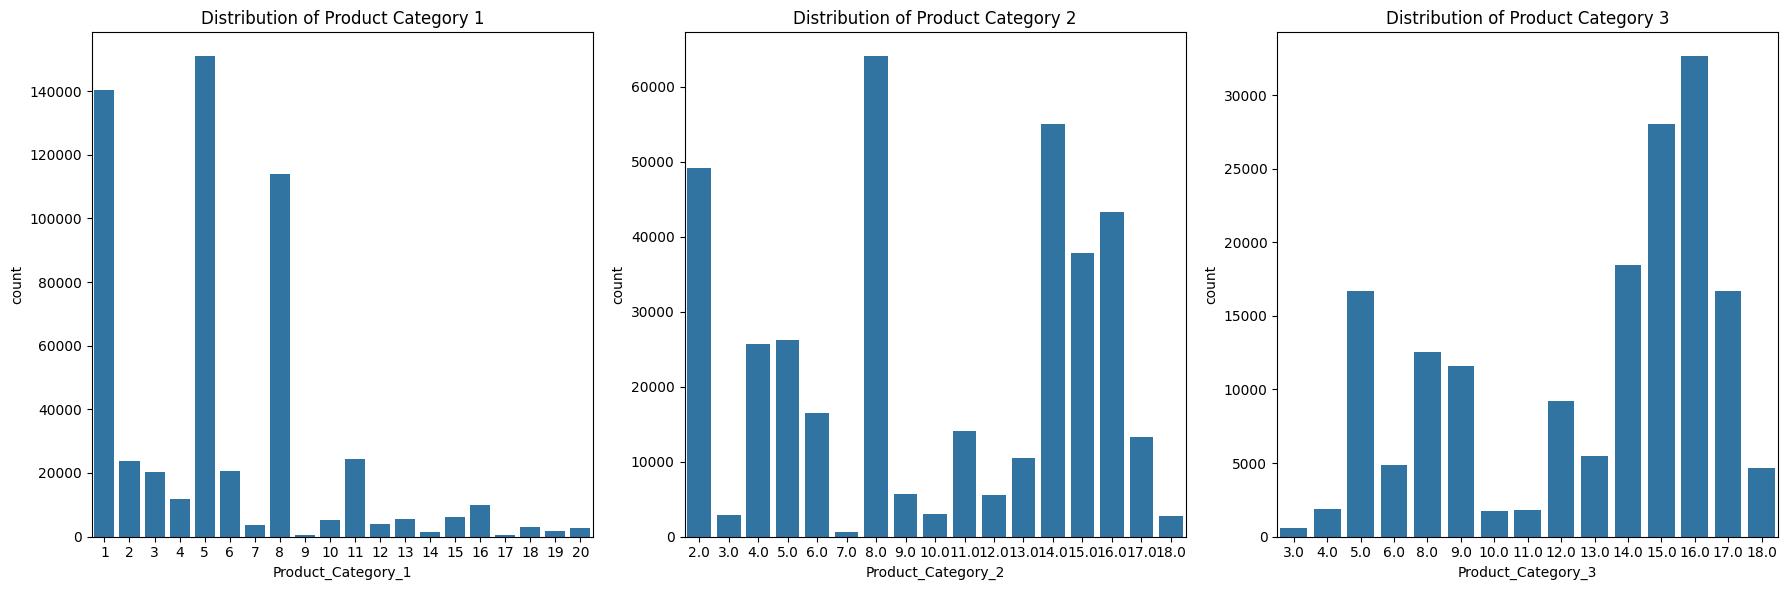

In [ ]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.countplot(x='Product_Category_1', data=black_sale_data)
plt.title('Distribution of Product Category 1')

plt.subplot(1, 3, 2)
sns.countplot(x='Product_Category_2', data=black_sale_data)
plt.title('Distribution of Product Category 2')

plt.subplot(1, 3, 3)
sns.countplot(x='Product_Category_3', data=black_sale_data)
plt.title('Distribution of Product Category 3')

plt.tight_layout()
plt.show()

No queda del todo claro si se utilizan los mismos identificadores para las mismas categorías, que podrían ser en algunos casos la principal para un producto, y la secundaria o terciaria para otro. Conocer esto no es estrictamente necesario para procesar los datos y entrenar un modelo, pero serviría para explorar alternativas como la creación de features que indique que un producto ***tiene la categoría x en alguna de las columnas correspondientes***. Esto sería útil para reducir features, pero de este gráfico podemos ver, que al menos para algunos casos, podría tener mucho peso en el precio que el identificador de la categoría esté en la columna 1 o bien en la columna 2 o 3. Por tanto, no parece una buena idea utilizar una estrategia como esta, y parece que lo mejor es tratar cada feature de forma independiente.

Lo que si queremos explorar, a continuación, es si tenemos valores faltantes en las columnas `Product_Category_2` y `Product_Category_3`, o simplemente se trata de productos con una/dos categorías, y no tres que lo describan. Para eso, comparemos en todos los datos, si para mismo `Product_ID` tenemos los mismos valores en las 3 columnas, incluyendo los mismos faltantes.

In [ ]:
duplicates = black_sale_data[black_sale_data.duplicated(subset=['Product_ID'], keep=False)]

# Agrupamos por product ID
product_category_variations = duplicates.groupby('Product_ID').agg({'Product_Category_1': 'nunique',
                                                                   'Product_Category_2': 'nunique',
                                                                   'Product_Category_3': 'nunique'})

# Filtramos por productos con cualquier variación en las columnas de Product_Category_N
products_with_variations = product_category_variations[
    (product_category_variations['Product_Category_1'] > 1) |
    (product_category_variations['Product_Category_2'] > 1) |
    (product_category_variations['Product_Category_3'] > 1)
]

print("Product IDs with different category combinations:")
print(products_with_variations.index.tolist())

Product IDs with different category combinations:
[]


Al no haber casos, y siendo que como vimos antes, siempre tienen al menos una categoría, vamos a suponer que los productos pueden tener una o dos categorías, y que el faltante es descriptivo del producto.

Veamos algunas distribuciones de las observaciones según algunas features, y a su vez, distribuciones del target `Purchase` según las mismas.

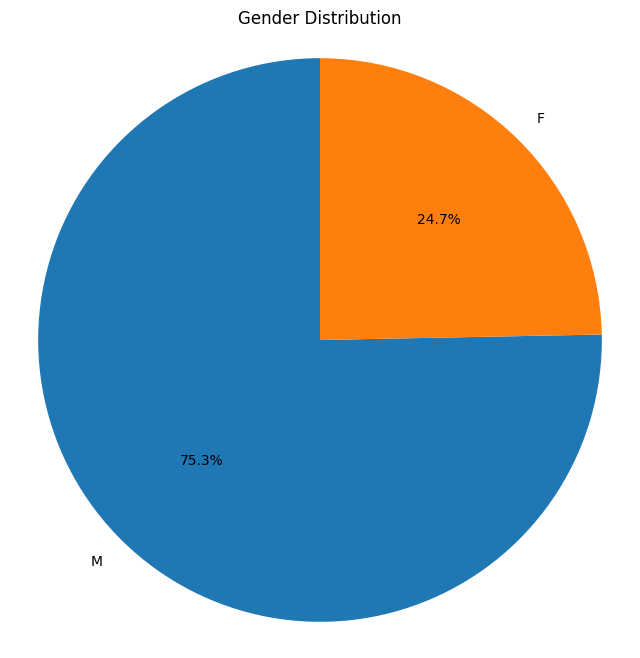

In [ ]:
gender_counts = black_sale_data['Gender'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution')
plt.axis('equal')
plt.show()

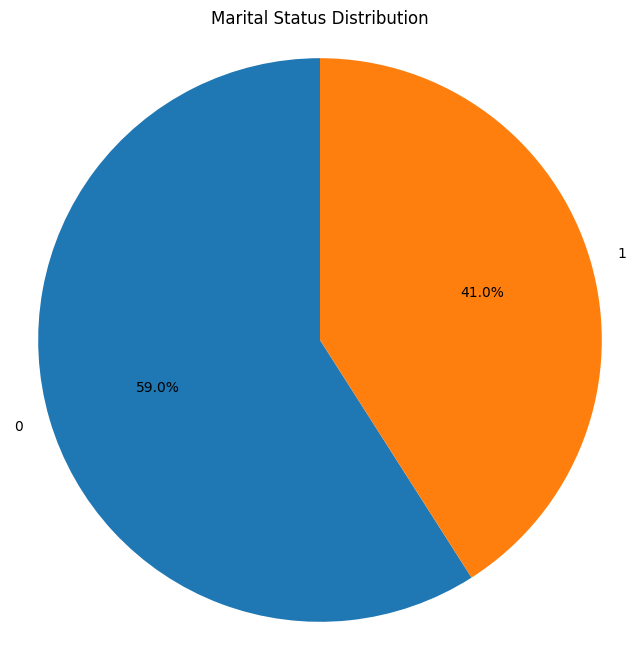

In [ ]:
marital_status_counts = black_sale_data['Marital_Status'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(marital_status_counts, labels=marital_status_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Marital Status Distribution')
plt.axis('equal')
plt.show()

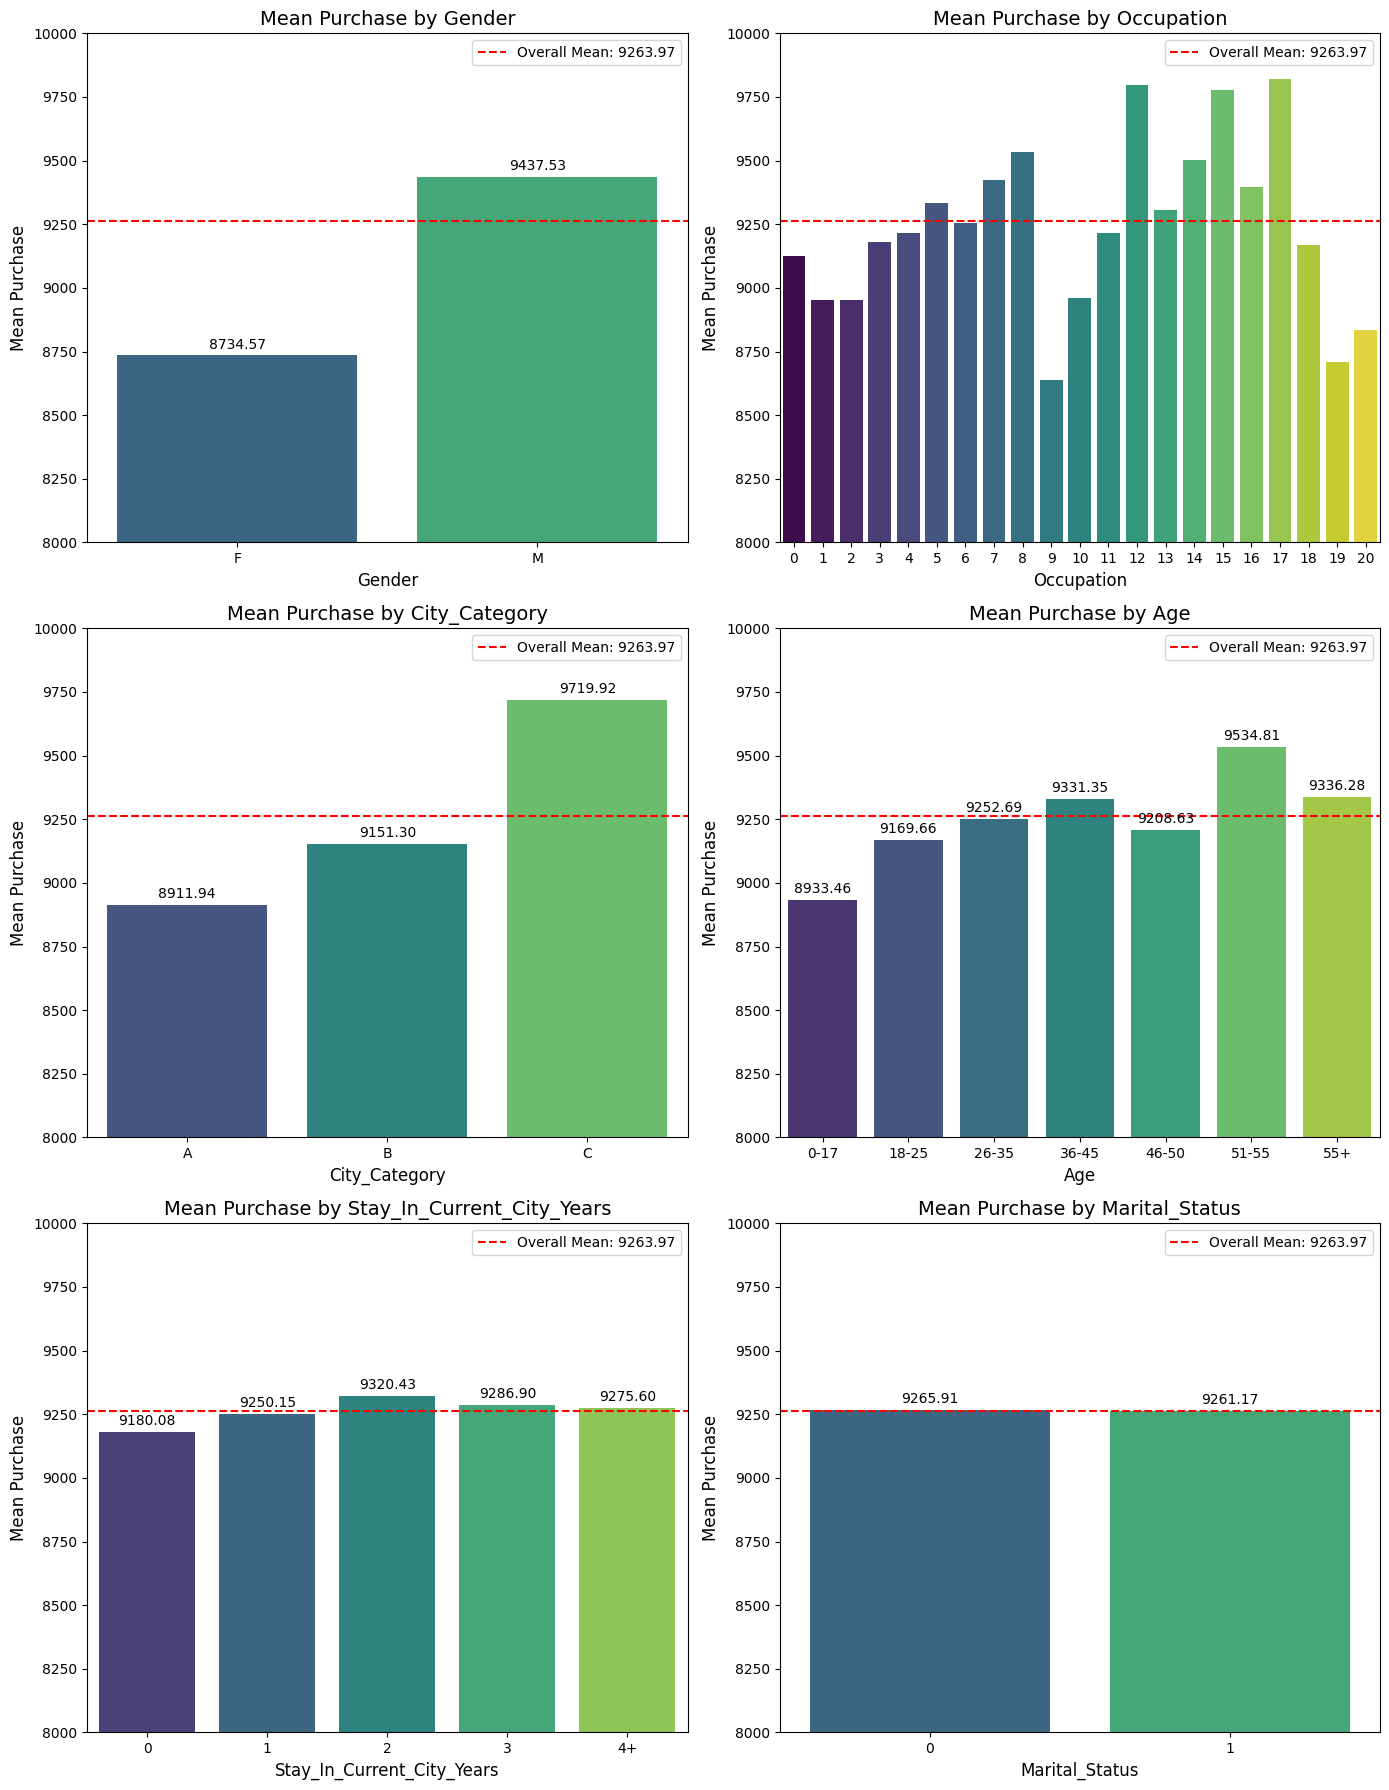

In [ ]:
features = ['Gender', 'Occupation', 'City_Category', 'Age', 'Stay_In_Current_City_Years', 'Marital_Status']

fig, axes = plt.subplots(3, 2, figsize=(14, 18)) # Configurar 3 filas y 2 columnas
axes = axes.flatten()

overall_mean = black_sale_data['Purchase'].mean() # Media general de 'Purchase'

for i, feature in enumerate(features):
    ax = axes[i]

    # Calcular la media de compra por característica
    purchase_mean_by_feature = black_sale_data.groupby(feature)['Purchase'].mean()

    # Crear el gráfico de barras
    sns.barplot(
        x=purchase_mean_by_feature.index,
        y=purchase_mean_by_feature.values,
        ax=ax,
        palette="viridis",
        hue=purchase_mean_by_feature.index,
        dodge=False,
        legend=False
    )

    # Fijar rango del eje Y
    ax.set_ylim(8000, 10000)

    # Agregar línea de referencia para la media general
    ax.axhline(overall_mean, color='red', linestyle='--', label=f'Overall Mean: {overall_mean:.2f}')

    ax.set_title(f'Mean Purchase by {feature}', fontsize=14)
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Mean Purchase', fontsize=12)

    # Agregar etiquetas de valores en las barras
    if (feature != 'Occupation'):
      for p in ax.patches:
          ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

    ax.legend()

plt.tight_layout()
plt.show()

Información que podemos extraer de estos gráficos:
- Las compras realizadas por hombres tienen en promedio un valor superior al de las realizadas por mujeres.
- Perece haber una relación entre la categoría de la ciudad y el precio, dado que las compras en ciudades de categoría C son marcadamente superiores a B, y B superiores a su vez a A.
- No se observan diferencias el estado civil y el precio de la compra.
- Con la edad ocurre un crecimiento del valor de las compras, hasta el rango de 46-50, siendo luego el máximo alcanzado en 51-55 para volver a caer.

Finalmente, veamos la distribución de los valores de compra de los productos. Para ello, usemos bins de 1000, dado que los límites pedidos de los grupos están definidos en 5000, 10000 y 15000:

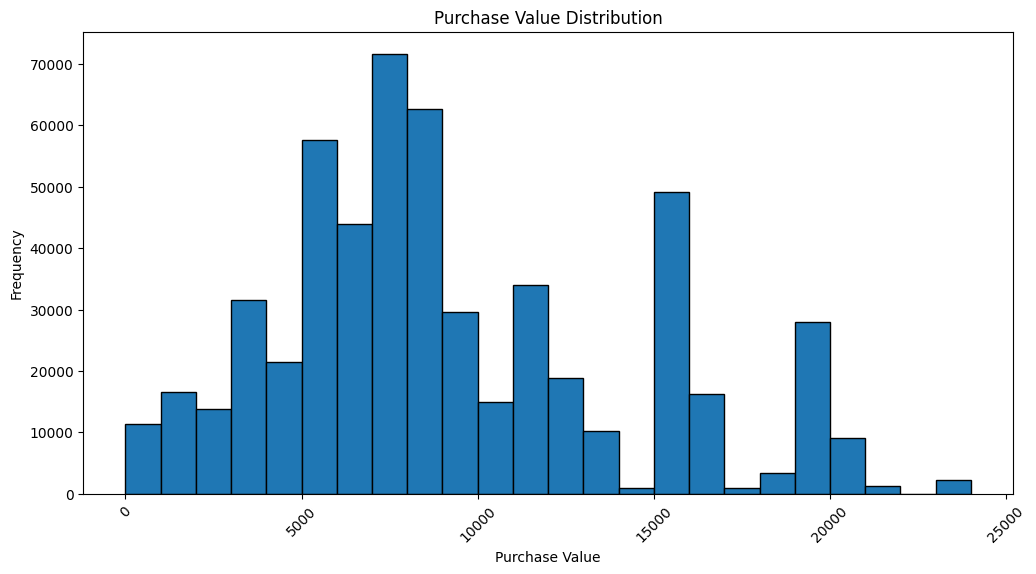

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(black_sale_data['Purchase'], bins=range(0, int(black_sale_data['Purchase'].max()) + 1000, 1000), edgecolor='black')
plt.xlabel('Purchase Value')
plt.ylabel('Frequency')
plt.title('Purchase Value Distribution')
plt.xticks(rotation=45)
plt.show()



A este punto podemos identificar que los datos pueden ser problemáticos para la tarea solicitada, dados los picos en 5000, 1000, 15000 (valores que delimitan las categorías a predecir). En la distribución podemos ver que muchas observaciones están entre 5000 y 6000, y entre 9000 y 10000. Por otro lado, una situación aún más marcada tenemos justo por encima de los 15000.
Estas características del set de datos podrían complicar al modelo a predecir correctamente el grupo de comprador.

### Feature Engineering ###

Procedemos con el procesamiento de nuestras features:
- Completar las missing de `Product_Category_2`, `Product_Category_3` con -1 (dado que se identificó que no es una cuestión de error en carga de datos)
- Aplicamos One hot encoding en las categorías no ordinales con las que contamos: `Product_Category_1`, `Product_Category_2`, `Product_Category_3`, `Occupation`, `Gender`, `Marital_Status`.
- Convertimos las categorías de `Age` a enteros, entendiendo que hay un orden (aunque no haya una correlación lineal con el precio de la compra).
- Convertimos `Stay_In_Current_City_Years` a entero (el caso faltante 4+).
- Convertimos `City_Category` a entero, entendiendo que hay un orden implícito en la categoría.

In [5]:
black_sale_data_processed = black_sale_data.copy()

In [6]:
for col in ['Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'Occupation']:
    black_sale_data_processed[col] = black_sale_data_processed[col].fillna(-1).astype(int)

In [7]:
age_map = {
    '0-17': 0,
    '18-25': 1,
    '26-35': 2,
    '36-45': 3,
    '46-50': 4,
    '51-55': 5,
    '55+': 6
}
black_sale_data_processed['Age'] = black_sale_data_processed['Age'].map(age_map)

In [8]:
city_category_mapping = {'A': 3, 'B': 2, 'C': 1}
black_sale_data_processed['City_Category'] = black_sale_data_processed['City_Category'].map(city_category_mapping)

In [9]:
black_sale_data_processed['Stay_In_Current_City_Years'] = black_sale_data_processed['Stay_In_Current_City_Years'].replace('4+', 4).astype(int)

In [10]:
black_sale_data_processed['Marital_Status'] = black_sale_data_processed['Marital_Status'].map({0: 'Single', 1: 'Married'})

In [11]:
black_sale_data_processed = pd.get_dummies(black_sale_data_processed, columns=['Gender', 'Marital_Status', 'Occupation'], drop_first=True)

In [12]:
# Create a copy of the original DataFrame for adding extra columns
black_sale_data_processed_with_extra_columns = black_sale_data_processed.copy()

# Identify all unique product categories from Product_Category_1, 2, and 3
unique_categories = set(black_sale_data_processed_with_extra_columns[['Product_Category_1', 'Product_Category_2', 'Product_Category_3']].stack())

# Iterate through each unique category and create a new column
for category in unique_categories:
    black_sale_data_processed_with_extra_columns[f'Has_Product_Category_{category}'] = (
        (black_sale_data_processed_with_extra_columns['Product_Category_1'] == category) |
        (black_sale_data_processed_with_extra_columns['Product_Category_2'] == category) |
        (black_sale_data_processed_with_extra_columns['Product_Category_3'] == category)
    ).astype(int)
black_sale_data_processed_with_extra_columns = black_sale_data_processed_with_extra_columns.drop(columns=['Has_Product_Category_-1'])

In [13]:
black_sale_data_processed = pd.get_dummies(black_sale_data_processed, columns=['Product_Category_1', 'Product_Category_2', 'Product_Category_3'], drop_first=True)


In [14]:
black_sale_data_processed

,User_ID,Product_ID,Age,City_Category,Stay_In_Current_City_Years,Purchase,Gender_M,Marital_Status_Single,Occupation_1,Occupation_2,...,Product_Category_3_9,Product_Category_3_10,Product_Category_3_11,Product_Category_3_12,Product_Category_3_13,Product_Category_3_14,Product_Category_3_15,Product_Category_3_16,Product_Category_3_17,Product_Category_3_18
0,1000001,P00069042,0,3,2,8370,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1000001,P00248942,0,3,2,15200,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
2,1000001,P00087842,0,3,2,1422,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1000001,P00085442,0,3,2,1057,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1000002,P00285442,6,1,4,7969,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550063,1006033,P00372445,5,2,1,368,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
550064,1006035,P00375436,2,1,3,371,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
550065,1006036,P00375436,2,2,4,137,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
550066,1006038,P00375436,6,1,2,365,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False


In [15]:
bins = [0, 5000, 10000, 15000, float('inf')] # Límites de los rangos
labels = [0, 1, 2, 3] # Grupos correspondientes
black_sale_data_processed['Purchase_Group'] = pd.cut(
    black_sale_data_processed['Purchase'],
    bins=bins,
    labels=labels,
    right=False # Excluye el límite superior del rango
)

In [16]:
black_sale_data_processed['Purchase_Group'] = pd.to_numeric(black_sale_data_processed['Purchase_Group'], errors='coerce')
purchase_group_counts = black_sale_data_processed['Purchase_Group'].value_counts().sort_index()
print(purchase_group_counts)

Purchase_Group
0     94923
1    265606
2     79016
3    110523
Name: count, dtype: int64


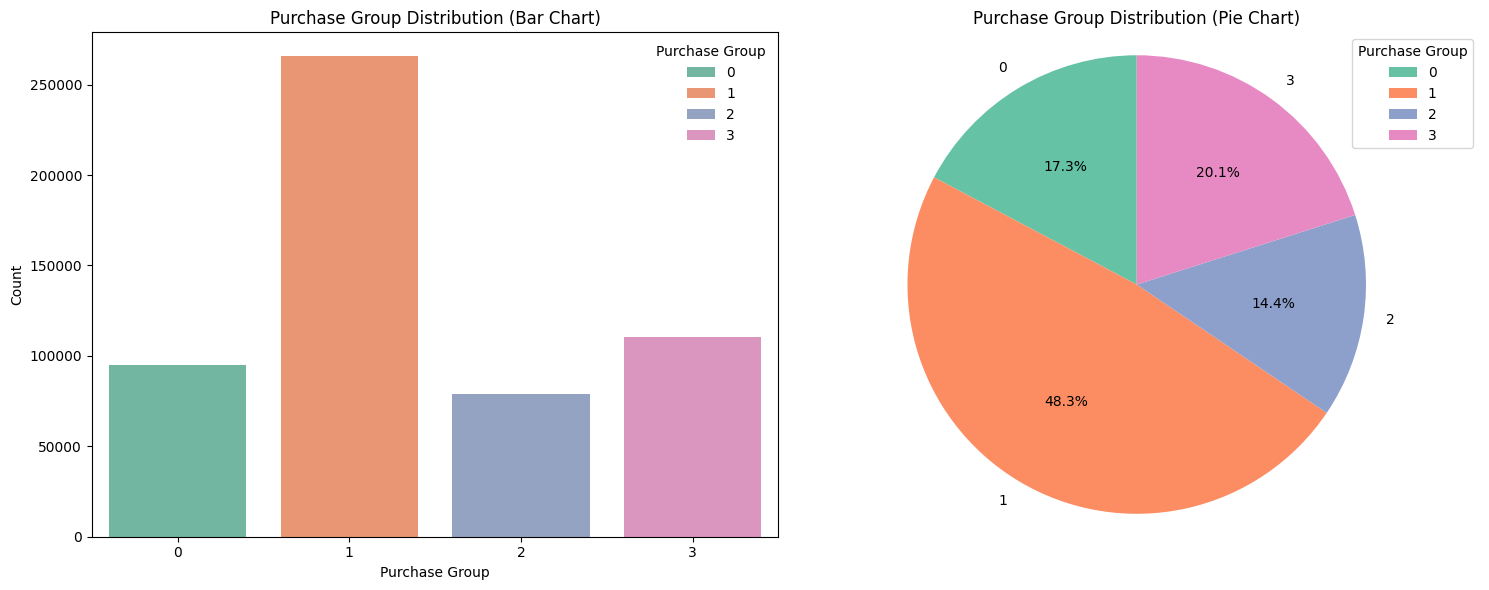

In [17]:
purchase_group_counts = black_sale_data_processed['Purchase_Group'].value_counts()
purchase_group_counts = purchase_group_counts.sort_index()

fixed_colors = sns.color_palette("Set2", len(purchase_group_counts))

color_dict = {str(group): color for group, color in zip(purchase_group_counts.index, fixed_colors)}

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(x=purchase_group_counts.index, y=purchase_group_counts.values, ax=axes[0], hue=purchase_group_counts.index, palette=fixed_colors)
axes[0].set_title('Purchase Group Distribution (Bar Chart)')
axes[0].set_xlabel('Purchase Group')
axes[0].set_ylabel('Count')
axes[0].legend(title='Purchase Group', loc='best', frameon=False)

axes[1].pie(purchase_group_counts, labels=purchase_group_counts.index.astype(str), autopct='%1.1f%%', startangle=90, colors=fixed_colors)
axes[1].set_title('Purchase Group Distribution (Pie Chart)')
axes[1].axis('equal')
axes[1].legend(purchase_group_counts.index.astype(str), title='Purchase Group', loc='best')

plt.tight_layout()
plt.show()

Podemos observar que los grupos de compradores nos quedan desbalanceados, siendo con diferencia (casi un 50%) compradores de categoría 1, seguidos de compradores de categoría 3 con un 20,1%.

Para tener un primer benchmark antes de entrenar cualquier modelo, podríamos decir que la heurística más básica que eligiese siempre la categoría más popular, acertaría con una precisión del 48,3%,


Además, viendo la distribución de `Purchase` original, habiamos mencionado que muchas observaciones estaban cerca de su grupo vecino. Plasmemos eso en números, identificando cuantas observaciones están a menos de 500 unidades del grupo vecino más cercano. Esto corresponde a un 10% del valor del rango:

In [18]:
tolerance = 500

# Crear una función para verificar si una observación está dentro de 500 unidades del límite
def count_near_boundaries(row, bins, tolerance):
    for i in range(1, len(bins)):
        # Verificar si la observación está cerca del límite superior o inferior de un bin
        if abs(row - bins[i-1]) < tolerance or abs(row - bins[i]) < tolerance:
            return True
    return False

black_sale_data_processed_copy = black_sale_data_processed.copy()
# Aplicar la función a las observaciones
black_sale_data_processed_copy['Near_Boundary'] = black_sale_data_processed_copy['Purchase'].apply(
    lambda x: count_near_boundaries(x, bins, tolerance)
)

# Contar el número de observaciones cerca de los límites (Near_Boundary == True)
near_boundary_count = black_sale_data_processed_copy['Near_Boundary'].sum()

# Calcular el porcentaje de observaciones cerca de los límites
total_count = len(black_sale_data_processed_copy)
near_boundary_percentage = (near_boundary_count / total_count) * 100

print(f"Porcentaje de observaciones cerca de los límites: {near_boundary_percentage:.2f}%")

Porcentaje de observaciones cerca de los límites: 20.27%


Con esto confirmamos un poco lo expuesto. 1 de cada 5 observaciones están cerca de su grupo vecino más próximo.

Finalmente, confirmamos que no quedaron valores faltantes en ninguna columna:

In [19]:
for col in black_sale_data_processed.columns:
  print(f"Column '{col}': Number of NaN values - {black_sale_data_processed[col].isna().sum()}")

Column 'User_ID': Number of NaN values - 0
Column 'Product_ID': Number of NaN values - 0
Column 'Age': Number of NaN values - 0
Column 'City_Category': Number of NaN values - 0
Column 'Stay_In_Current_City_Years': Number of NaN values - 0
Column 'Purchase': Number of NaN values - 0
Column 'Gender_M': Number of NaN values - 0
Column 'Marital_Status_Single': Number of NaN values - 0
Column 'Occupation_1': Number of NaN values - 0
Column 'Occupation_2': Number of NaN values - 0
Column 'Occupation_3': Number of NaN values - 0
Column 'Occupation_4': Number of NaN values - 0
Column 'Occupation_5': Number of NaN values - 0
Column 'Occupation_6': Number of NaN values - 0
Column 'Occupation_7': Number of NaN values - 0
Column 'Occupation_8': Number of NaN values - 0
Column 'Occupation_9': Number of NaN values - 0
Column 'Occupation_10': Number of NaN values - 0
Column 'Occupation_11': Number of NaN values - 0
Column 'Occupation_12': Number of NaN values - 0
Column 'Occupation_13': Number of NaN

In [20]:
def evaluate_classifier(classifier, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    if hasattr(classifier, "predict_proba"):
        y_prob = classifier.predict_proba(X_test_scaled)
        auc_score = roc_auc_score(y_test, y_prob, multi_class='ovr')
        print(f"AUC Score: {auc_score:.4f}")

    conf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

### Feature Engineering Alternativo (Age con One Hot Encoding) ###

In [49]:
black_sale_data_processed_alternative = black_sale_data.copy()

In [50]:
for col in ['Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'Occupation']:
    black_sale_data_processed_alternative[col] = black_sale_data_processed_alternative[col].fillna(-1).astype(int)

In [51]:
black_sale_data_processed_alternative['Age'] = black_sale_data_processed_alternative['Age'].astype('category')
black_sale_data_processed_alternative = pd.get_dummies(black_sale_data_processed_alternative, columns=['Age'], prefix='Age', drop_first=True)

In [52]:
black_sale_data_processed_alternative

,User_ID,Product_ID,Gender,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+
0,1000001,P00069042,F,10,A,2,0,3,-1,-1,8370,False,False,False,False,False,False
1,1000001,P00248942,F,10,A,2,0,1,6,14,15200,False,False,False,False,False,False
2,1000001,P00087842,F,10,A,2,0,12,-1,-1,1422,False,False,False,False,False,False
3,1000001,P00085442,F,10,A,2,0,12,14,-1,1057,False,False,False,False,False,False
4,1000002,P00285442,M,16,C,4+,0,8,-1,-1,7969,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550063,1006033,P00372445,M,13,B,1,1,20,-1,-1,368,False,False,False,False,True,False
550064,1006035,P00375436,F,1,C,3,0,20,-1,-1,371,False,True,False,False,False,False
550065,1006036,P00375436,F,15,B,4+,1,20,-1,-1,137,False,True,False,False,False,False
550066,1006038,P00375436,F,1,C,2,0,20,-1,-1,365,False,False,False,False,False,True


In [53]:
city_category_mapping = {'A': 3, 'B': 2, 'C': 1}
black_sale_data_processed_alternative['City_Category'] = black_sale_data_processed_alternative['City_Category'].map(city_category_mapping)

In [54]:
black_sale_data_processed_alternative['Stay_In_Current_City_Years'] = black_sale_data_processed_alternative['Stay_In_Current_City_Years'].replace('4+', 4).astype(int)

In [55]:
black_sale_data_processed_alternative['Marital_Status'] = black_sale_data_processed_alternative['Marital_Status'].map({0: 'Single', 1: 'Married'})

In [56]:
black_sale_data_processed_alternative = pd.get_dummies(black_sale_data_processed_alternative, columns=['Gender', 'Marital_Status', 'Occupation'], drop_first=True)

In [57]:
black_sale_data_processed_alternative = pd.get_dummies(black_sale_data_processed_alternative, columns=['Product_Category_1', 'Product_Category_2', 'Product_Category_3'], drop_first=True)


In [58]:
bins = [0, 5000, 10000, 15000, float('inf')] # Límites de los rangos
labels = [0, 1, 2, 3] # Grupos correspondientes
black_sale_data_processed_alternative['Purchase_Group'] = pd.cut(
    black_sale_data_processed_alternative['Purchase'],
    bins=bins,
    labels=labels,
    right=False # Excluye el límite superior del rango
)

## Entrenamiento de modelos básicos (b)

Ya mencinamos como primer benchmark la utilización del grupo con más ocurrencias como predicción. Esto resultaría con un 48,3% de precisión.

A continuación entrenemos 3 modelos: una regresión logística, un random forest y cat boost, para encontrar nuevas métricas. En todos los casos, obtendremos los valores de precisión y precisión balanceada.

In [ ]:
X = black_sale_data_processed.drop(columns=['Purchase', 'Purchase_Group', 'User_ID', 'Product_ID'])
y = black_sale_data_processed['Purchase_Group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
logistic_regression_classifier = LogisticRegression(max_iter=1000, random_state=42)
logistic_regression_classifier.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

Accuracy: 0.7128
Balanced Accuracy: 0.6267
Precision: 0.7252
Recall: 0.7128
F1-Score: 0.6938

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.45      0.58     18985
           1       0.82      0.84      0.83     53121
           2       0.53      0.27      0.35     15803
           3       0.57      0.95      0.71     22105

    accuracy                           0.71    110014
   macro avg       0.68      0.63      0.62    110014
weighted avg       0.73      0.71      0.69    110014

AUC Score: 0.8667


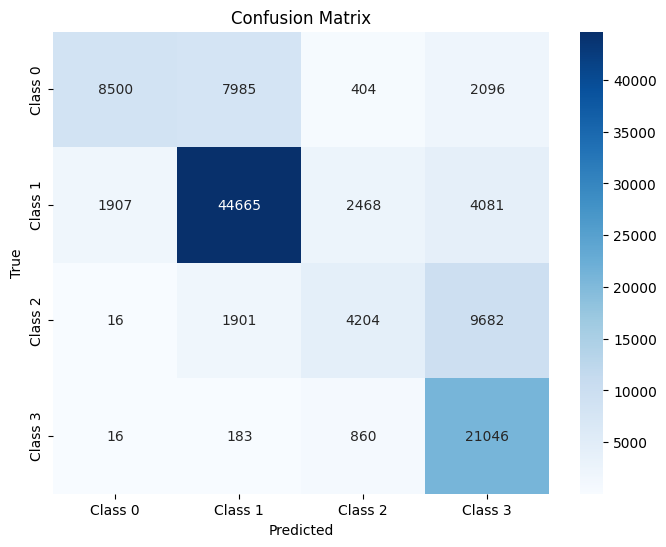

In [ ]:
y_pred_logistic = logistic_regression_classifier.predict(X_test_scaled)
evaluate_classifier(logistic_regression_classifier, y_pred_logistic)

Con este primer modelo conseguimos un accuracy del 71,26% pero un balanced accuracy de tan solo el 62,66%, lo cual confirma la complicación del modelo de predecir las clases minoritarias. Veamoslo en una matriz de confusión.

In [ ]:
random_forest_classifier = RandomForestClassifier(random_state=42)
random_forest_classifier.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

Accuracy: 0.6935
Balanced Accuracy: 0.6054
Precision: 0.6886
Recall: 0.6935
F1-Score: 0.6832

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.46      0.56     18985
           1       0.78      0.85      0.82     53121
           2       0.43      0.36      0.39     15803
           3       0.62      0.75      0.68     22105

    accuracy                           0.69    110014
   macro avg       0.64      0.61      0.61    110014
weighted avg       0.69      0.69      0.68    110014

AUC Score: 0.8584


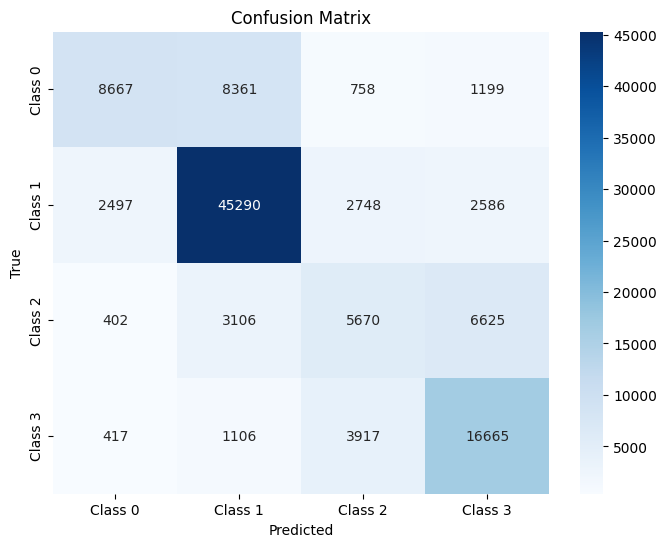

In [ ]:
y_pred_random_forest = random_forest_classifier.predict(X_test_scaled)
evaluate_classifier(random_forest_classifier, y_pred_random_forest)

In [ ]:
catboost_classifier = CatBoostClassifier(random_state=42, verbose=0)
catboost_classifier.fit(X_train_scaled, y_train)

Accuracy: 0.7177
Balanced Accuracy: 0.6314
Precision: 0.7270
Recall: 0.7177
F1-Score: 0.6997

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.44      0.58     18985
           1       0.81      0.85      0.83     53121
           2       0.52      0.29      0.37     15803
           3       0.59      0.94      0.72     22105

    accuracy                           0.72    110014
   macro avg       0.69      0.63      0.63    110014
weighted avg       0.73      0.72      0.70    110014

AUC Score: 0.8799


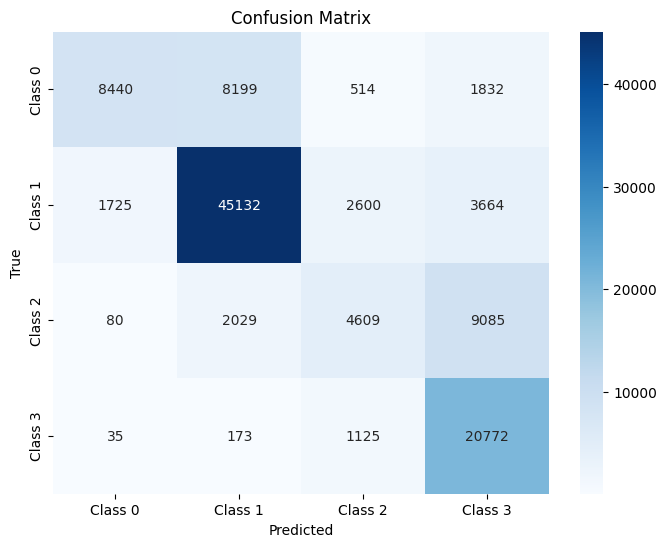

In [ ]:
y_pred_catboost = catboost_classifier.predict(X_test_scaled)
evaluate_classifier(catboost_classifier, y_pred_catboost)

Con CatBoost presentamos los mejores resultados, apenas por encima de los otros dos modelos.
Teniendo en consideración que no hicimos búsqueda de hiperparámetros, estos modelos al menos nos dan una buena base para empezar a trabajar con una red neuronal. La precisión balanceada a buscar debería ser superir a 65,03%


Por otra parte, amerita mencionar el problema que intuímos ibamos a tener por los datos y los rangos de precios de los grupos solicitados. Vemos que ambos modelos predicen muchos casos de Clase 0 como Clase 1 y Clase 2 como Clase 3. Los que mejor funcionan son las prediciones de Clase 1 y 3, dado que son las que más observaciones presentan. Este comportamiento está relacionado con la distribución analizada, con muchas observaciones cerca de los límites de los grupos definidos, que complican al modelo para diferenciar correctamente la clase.

## Entrenamiento de Red Neuronal ##

### Definición de clases y métodos generales ###

Definimos algunas clases que utilizaremos luego para probar distintas redes neuronales y ver como performan:

In [21]:
class BlackSaleDataset(Dataset):

  #__init__ guarda el dataset en una variable de clase
  def __init__(self, x, y):
    self.x = torch.tensor(x, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.long)

  # __len__ define el comportamiento de la función len() sobre el objeto
  def __len__(self):
    return len(self.x)

  # __getitem__ define el comportamiento de los []
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [22]:
class EarlyStopper:
    def __init__(self, patience=10, mode="min"):
        """
        Clase para implementar early stopping.

        Args:
            patience (int): Número de épocas sin mejora antes de detener el entrenamiento.
            mode (str): "min" para minimizar la métrica (ej., pérdida) o "max" para maximizar (ej., precisión).
        """
        self.patience = patience
        self.mode = mode
        self.best_score = float('inf') if mode == "min" else -float('inf')
        self.best_model_weights = None
        self.counter = 0

    def step(self, current_score, model):
        """
        Evalúa si se debe detener el entrenamiento.

        Args:
            current_score (float): Métrica actual (ej., pérdida o precisión).
            model (torch.nn.Module): Modelo a guardar si mejora.

        Returns:
            bool: True si se debe detener el entrenamiento.
        """
        if (self.mode == "min" and current_score < self.best_score) or \
           (self.mode == "max" and current_score > self.best_score):
            self.best_score = current_score
            self.best_model_weights = copy.deepcopy(model.state_dict())
            self.counter = 0
            print("It's learning!")
            return False  # No detener, hay mejora
        else:
            print(f"It's not learning... patience: {self.patience - self.counter}")
            self.counter += 1
            return self.counter >= self.patience

    def restore_best_weights(self, model):
        """Restaura los mejores pesos guardados en el modelo."""
        if self.best_model_weights:
            model.load_state_dict(self.best_model_weights)

In [23]:
def printTrainLossVsValidLossAndAccuracy(
    train_loss_by_epoch, valid_loss_by_epoch, train_accuracy_by_epoch, valid_accuracy_by_epoch
):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Two subplots side by side

    # Plot loss
    ax1.plot(train_loss_by_epoch, label="Train Loss", color="blue")
    ax1.plot(valid_loss_by_epoch, label="Validation Loss", color="orange")
    ax1.legend()
    ax1.set_title("Loss by Epoch")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("CrossEntropyLoss")

    # Plot balanced accuracy
    ax2.plot(train_accuracy_by_epoch, label="Train Balanced Accuracy", color="green")
    ax2.plot(valid_accuracy_by_epoch, label="Validation Balanced Accuracy", color="red")
    ax2.legend()
    ax2.set_title("Balanced Accuracy by Epoch")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Balanced Accuracy")
    ax2.set_ylim(0, 1)  # Ensure y-axis is fixed between 0 and 1

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

In [24]:
class Trainer:
    def __init__(self, model, device, optimizer, criterion, scheduler=None, early_stopper=None, save_best_model=False, best_model_name="best_model.pth"):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.early_stopper = early_stopper
        self.save_best_model = save_best_model
        self.best_model_name = best_model_name
        self.best_accuracy = 0
        self.train_loss_by_epoch = []
        self.valid_loss_by_epoch = []
        self.train_accuracy_by_epoch = []
        self.valid_accuracy_by_epoch = []

    def _process_batch(self, x_batch, y_batch, train=True):
        x_batch = x_batch.to(self.device).float()
        y_batch = y_batch.to(self.device).long()

        if train:
            self.optimizer.zero_grad()

        nnet_output = self.model(x_batch)
        loss = self.criterion(nnet_output, y_batch)

        if train:
            loss.backward()
            self.optimizer.step()

        _, y_batch_hat = torch.max(nnet_output, dim=1)
        return loss.item(), y_batch.cpu().numpy(), y_batch_hat.cpu().numpy()

    def _epoch(self, dataloader, train=True):
        mode = "train" if train else "eval"
        getattr(self.model, mode)()

        epoch_loss = 0
        epoch_y = []
        epoch_y_hat = []

        with torch.set_grad_enabled(train):
            for x_batch, y_batch in dataloader:
                loss, y_true, y_pred = self._process_batch(x_batch, y_batch, train)
                epoch_loss += loss
                epoch_y.extend(y_true)
                epoch_y_hat.extend(y_pred)

        epoch_loss /= len(dataloader)
        accuracy = accuracy_score(epoch_y, epoch_y_hat)
        balanced_accuracy = balanced_accuracy_score(epoch_y, epoch_y_hat)
        return epoch_loss, accuracy, balanced_accuracy

    def fit(self, train_dataloader, val_dataloader=None, epochs=10):
        for epoch in range(1, epochs + 1):
            print(f"Epoch {epoch}/{epochs}")

            # Training
            train_loss, train_accuracy, train_balanced_accuracy = self._epoch(train_dataloader, train=True)
            self.train_loss_by_epoch.append(train_loss)
            self.train_accuracy_by_epoch.append(train_balanced_accuracy)
            print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | Train Balanced Accuracy: {train_balanced_accuracy:.4f}")

            # Validation
            if val_dataloader:
                val_loss, val_accuracy, val_balanced_accuracy = self._epoch(val_dataloader, train=False)
                self.valid_loss_by_epoch.append(val_loss)
                self.valid_accuracy_by_epoch.append(val_balanced_accuracy)
                print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | Validation Balanced Accuracy: {val_balanced_accuracy:.4f}")

                # Save the best model
                if self.save_best_model and val_accuracy > self.best_accuracy:
                    self.best_accuracy = val_accuracy
                    torch.save(self.model.state_dict(), self.best_model_name)
                    print("Saved Best Model")

                # Early stopping
                if self.early_stopper and self.early_stopper.step(val_loss, self.model):
                    print(f"Early stopping triggered at epoch {epoch}")
                    break

            # Update learning rate with the scheduler
            if self.scheduler:
                # Step scheduler
                self.scheduler.step()

    def get_training_metrics(self):
        return self.train_loss_by_epoch, self.valid_loss_by_epoch, self.train_accuracy_by_epoch, self.valid_accuracy_by_epoch

    def predict(self, dataloader):
        self.model.eval()
        all_y_true = []
        all_y_pred = []

        with torch.no_grad():
            for x_batch, y_batch in dataloader:
                _, y_true, y_pred = self._process_batch(x_batch, y_batch, train=False)
                all_y_true.extend(y_true)
                all_y_pred.extend(y_pred)

        return np.array(all_y_true), np.array(all_y_pred)

## Entrenamiento de Red Neuronal sin embedding (c) ##



### Entrenamiendo de las redes neuronales ###

Siguiendo los pasos vistos en clase, convertimos los datos a numpy arrays, separamos en entrenamiento y testing y definimos las clases que utilizaremos para el entrenamiento de nuestras redes neuronales.

Primero, definiremos una primera red muy básica, para tener una primera solución al problema:

In [32]:
class NNet(torch.nn.Module):

  def __init__(self, input_size, output_size):
    # Defino la arquitectura de la red
    super().__init__()
    self.linear_1 = torch.nn.Linear(in_features=input_size, out_features=128, bias=True)
    self.relu_1 = torch.nn.ReLU()
    self.linear_2 = torch.nn.Linear(in_features=128, out_features=64, bias=True)
    self.relu_2 = torch.nn.ReLU()
    self.output = torch.nn.Linear(in_features=64, out_features=output_size, bias=True)

  def forward(self, x):
    # Defino el cálculo del paso forward
    x = self.linear_1(x)
    x = self.relu_1(x)
    x = self.linear_2(x)
    x = self.relu_2(x)
    x = self.output(x)
    return x

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Ahora si, procedemos al procesamiento de los datos y entrenamiento de la red:

In [26]:
X = black_sale_data_processed.drop(columns=['Purchase', 'Purchase_Group', 'User_ID', 'Product_ID'])
y = black_sale_data_processed['Purchase_Group']

X_numpy = X.to_numpy(dtype='float')
y_numpy = y.to_numpy(dtype='float')

X_train, X_test, y_train, y_test = train_test_split(X_numpy, y_numpy, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

train_black_sale_ds = BlackSaleDataset(X_train_scaled, y_train)
test_black_sale_ds = BlackSaleDataset(X_test_scaled, y_test)

train_dataloader = DataLoader(train_black_sale_ds, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_black_sale_ds, batch_size=64)

In [26]:
# Crear el modelo
nnet = NNet(input_size=X_train.shape[1], output_size=len(np.unique(y_train))).to(device)

# Configurar el optimizador y la función de pérdida
optimizer = optim.Adam(nnet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [29]:
trainer = Trainer(
    model=nnet,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    save_best_model=True,
    best_model_name="basic_nn.pth"
)

In [30]:
trainer.fit(
    train_dataloader=train_dataloader,
    val_dataloader=test_dataloader,
    epochs=50
)

Epoch 1/50
Train Loss: 0.7166 | Train Accuracy: 0.7109 | Train Balanced Accuracy: 0.6220
Validation Loss: 0.7089 | Validation Accuracy: 0.7134 | Validation Balanced Accuracy: 0.6268
Saved Best Model
Epoch 2/50
Train Loss: 0.7056 | Train Accuracy: 0.7142 | Train Balanced Accuracy: 0.6267
Validation Loss: 0.7061 | Validation Accuracy: 0.7141 | Validation Balanced Accuracy: 0.6277
Saved Best Model
Epoch 3/50
Train Loss: 0.7032 | Train Accuracy: 0.7149 | Train Balanced Accuracy: 0.6273
Validation Loss: 0.7068 | Validation Accuracy: 0.7144 | Validation Balanced Accuracy: 0.6278
Saved Best Model
Epoch 4/50
Train Loss: 0.7014 | Train Accuracy: 0.7153 | Train Balanced Accuracy: 0.6283
Validation Loss: 0.7050 | Validation Accuracy: 0.7144 | Validation Balanced Accuracy: 0.6307
Saved Best Model
Epoch 5/50
Train Loss: 0.6998 | Train Accuracy: 0.7157 | Train Balanced Accuracy: 0.6286
Validation Loss: 0.7033 | Validation Accuracy: 0.7140 | Validation Balanced Accuracy: 0.6287
Epoch 6/50
Train Loss:

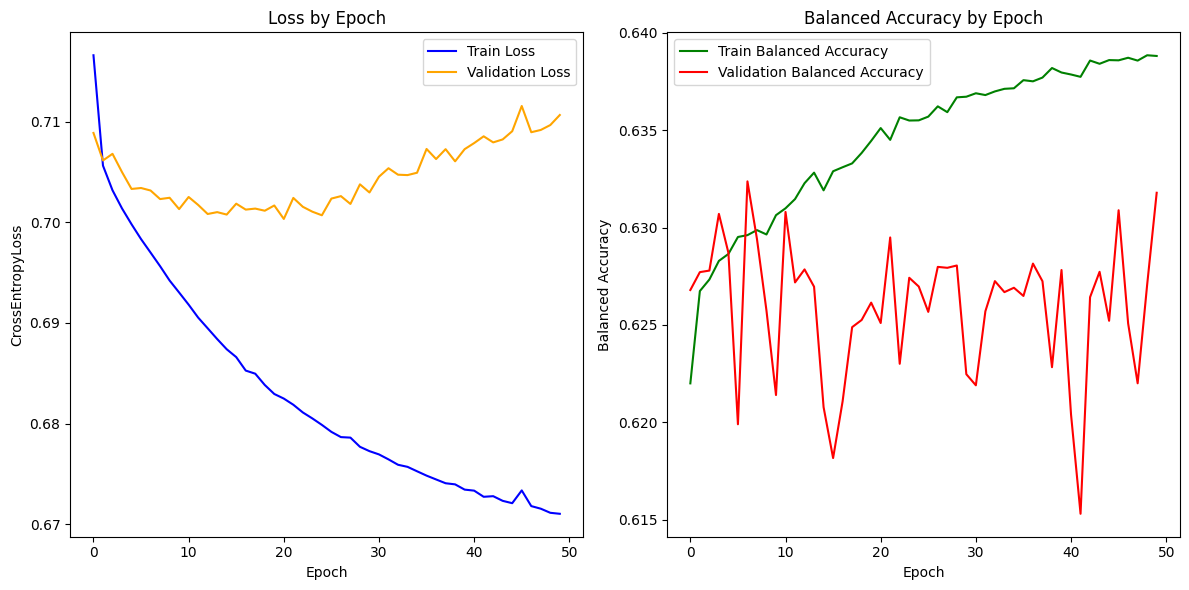

In [31]:
# Retrieve metrics
train_loss_by_epoch, valid_loss_by_epoch, train_accuracy_by_epoch, valid_accuracy_by_epoch = trainer.get_training_metrics()

# Plot metrics
printTrainLossVsValidLossAndAccuracy(
    train_loss_by_epoch,
    valid_loss_by_epoch,
    train_accuracy_by_epoch,
    valid_accuracy_by_epoch,
)

Accuracy: 0.7139
Balanced Accuracy: 0.6318
Precision: 0.7220
Recall: 0.7139
F1-Score: 0.7011

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.44      0.57     18985
         1.0       0.81      0.85      0.83     53121
         2.0       0.48      0.35      0.40     15803
         3.0       0.60      0.89      0.72     22105

    accuracy                           0.71    110014
   macro avg       0.68      0.63      0.63    110014
weighted avg       0.72      0.71      0.70    110014



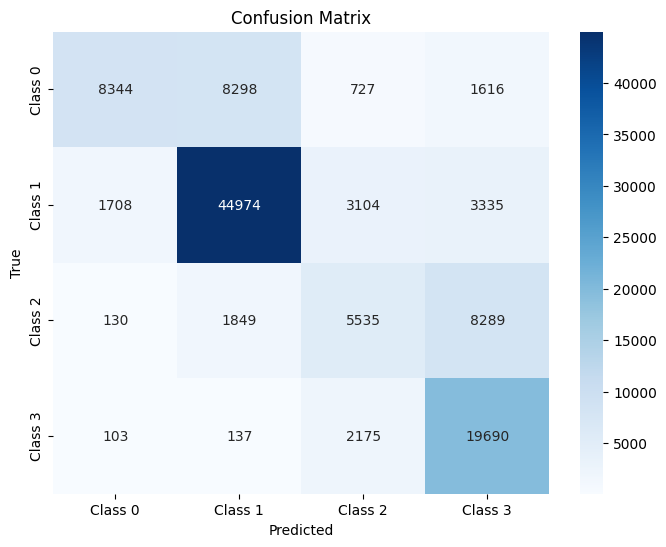

In [41]:
# Predict on test set
y_true, y_pred = trainer.predict(test_dataloader)

# Evaluate predictions
evaluate_classifier(nnet, y_pred)

Al parecer nuestra primer red neuronal está sufriendo overfitting. Disminuye de forma continua el train loss, mientras que el validation loss deja de mejorar rápidamente y vuelve a empeorar.

Además, vemos que conseguimos un 63,18% de precición balanceada, lo cual no es mejor que los modelos tradicionales.

Vamos a empezar con un par de mejoras en paralelo:
- Lo primero sería detener el entrenamiento si vemos que el conjunto de validación deja de mejorar. Para eso definimos en nuestro trainer la posibilidad de usar un early stopper, y así mismo definimos una clase para manejar esa lógica. De este modo tendremos un ahorro en el tiempo de entrenamiento
- Por otro lado, y quizás lo más importante, vamos a ajustar nuestra función de coste: CrossEntropyLoss no funciona bien con nuestra clase desbalanceada. Por lo tanto vamos a brindarle a la función un argumento weight, especialmente útil para datasets desbalanceados, para definir el peso de cada una de las clases.
- Finalmente, empecemos con alguna estrategia específica para disminuir el overfitting. Lo primero que haremos es aplicar una técnica de regularización L2 en el optimizador, utilizando el weight_decay del optimizador Adam.

In [33]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [45]:
# Crear el modelo
nnet = NNet(input_size=X_train.shape[1], output_size=len(np.unique(y_train))).to(device)

# Configurar el optimizador y la función de pérdida
optimizer = optim.Adam(nnet.parameters(), lr=0.001, weight_decay=0.001)

criterion = nn.CrossEntropyLoss(weight=class_weights)

In [47]:
trainer_v2 = Trainer(
    model=nnet,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    early_stopper=EarlyStopper(patience=5, mode="min"),
    save_best_model=True,
    best_model_name="nn_v2.pth"
)

Epoch 1/50
Train Loss: 0.8066 | Train Accuracy: 0.7034 | Train Balanced Accuracy: 0.6341
Validation Loss: 0.7982 | Validation Accuracy: 0.7101 | Validation Balanced Accuracy: 0.6370
Saved Best Model
It's learning!
Epoch 2/50
Train Loss: 0.7972 | Train Accuracy: 0.7068 | Train Balanced Accuracy: 0.6368
Validation Loss: 0.7977 | Validation Accuracy: 0.7069 | Validation Balanced Accuracy: 0.6356
It's learning!
Epoch 3/50
Train Loss: 0.7955 | Train Accuracy: 0.7076 | Train Balanced Accuracy: 0.6377
Validation Loss: 0.7990 | Validation Accuracy: 0.7078 | Validation Balanced Accuracy: 0.6370
It's not learning... patience: 5
Epoch 4/50
Train Loss: 0.7949 | Train Accuracy: 0.7075 | Train Balanced Accuracy: 0.6378
Validation Loss: 0.7959 | Validation Accuracy: 0.7007 | Validation Balanced Accuracy: 0.6366
It's learning!
Epoch 5/50
Train Loss: 0.7945 | Train Accuracy: 0.7070 | Train Balanced Accuracy: 0.6381
Validation Loss: 0.7946 | Validation Accuracy: 0.7083 | Validation Balanced Accuracy: 0.

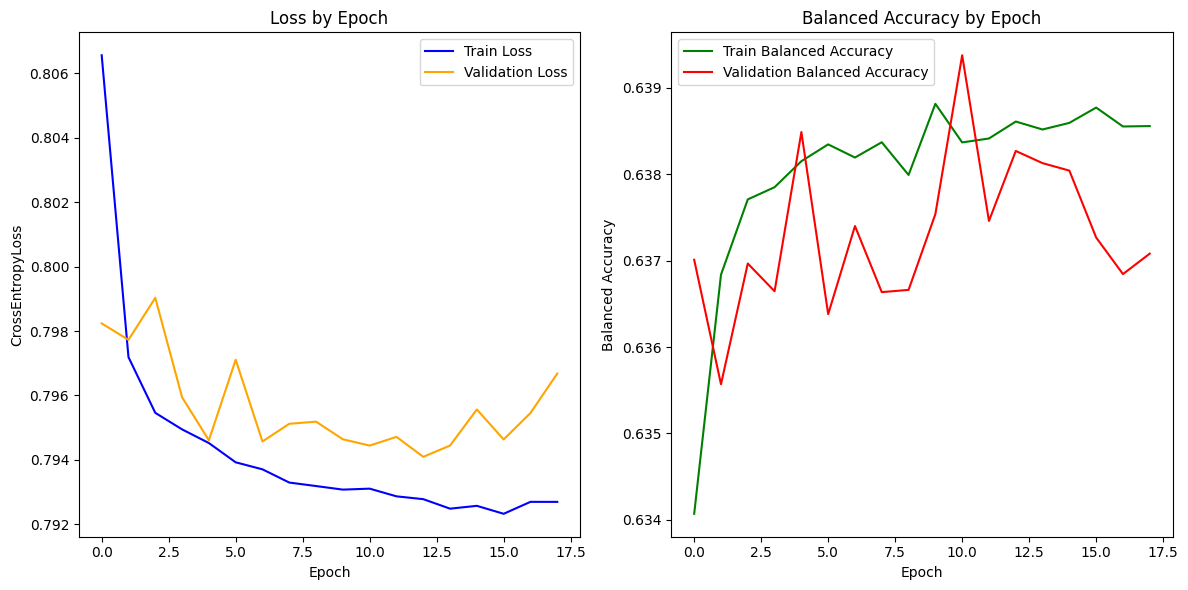

Accuracy: 0.7057
Balanced Accuracy: 0.6371
Precision: 0.7226
Recall: 0.7057
F1-Score: 0.7029

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.45      0.58     18985
         1.0       0.83      0.83      0.83     53121
         2.0       0.42      0.46      0.44     15803
         3.0       0.61      0.81      0.70     22105

    accuracy                           0.71    110014
   macro avg       0.67      0.64      0.64    110014
weighted avg       0.72      0.71      0.70    110014



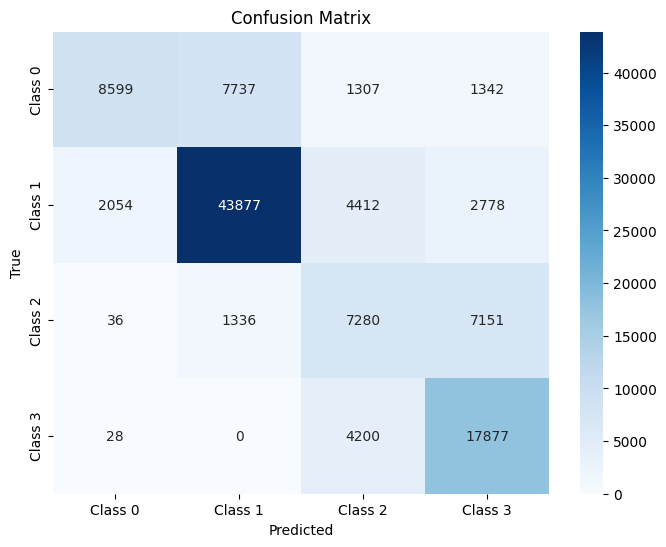

In [48]:
trainer_v2.fit(
    train_dataloader=train_dataloader,
    val_dataloader=test_dataloader,
    epochs=50
)

# Retrieve metrics
train_loss_by_epoch, valid_loss_by_epoch, train_accuracy_by_epoch, valid_accuracy_by_epoch = trainer.get_training_metrics()

# Plot metrics
printTrainLossVsValidLossAndAccuracy(
    train_loss_by_epoch,
    valid_loss_by_epoch,
    train_accuracy_by_epoch,
    valid_accuracy_by_epoch,
)

# Predict on test set
y_true, y_pred = trainer_v2.predict(test_dataloader)

# Evaluate predictions
evaluate_classifier(nnet, y_pred)

En este punto ya no estaríamos hablando de overfitting sino mas bien de underfitting, dado que la función de pérdida da similar para entrenamiento y validación (aunque no se consigue una reducción sostenida en esta última). Es muy probable que las features utilizadas no sean suficientes para lograr un gran resultado, pero antes de pasar a entrenar un modelo con embeddings, vamos a tratar una alternativa en el tratamiento de los datos.

Antes asumimos la edad como una variable categórica ordinal, vamos en su lugar a utilizar one hot encoding, y volver a entrenar esta red con el nuevo dataset:

In [59]:
X = black_sale_data_processed_alternative.drop(columns=['Purchase', 'Purchase_Group', 'User_ID', 'Product_ID'])
y = black_sale_data_processed_alternative['Purchase_Group']

X_numpy = X.to_numpy(dtype='float')
y_numpy = y.to_numpy(dtype='float')

X_train, X_test, y_train, y_test = train_test_split(X_numpy, y_numpy, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

train_black_sale_ds = BlackSaleDataset(X_train_scaled, y_train)
test_black_sale_ds = BlackSaleDataset(X_test_scaled, y_test)

train_dataloader = DataLoader(train_black_sale_ds, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_black_sale_ds, batch_size=64)

In [34]:
# Crear el modelo
nnet = NNet(input_size=X_train.shape[1], output_size=len(np.unique(y_train))).to(device)

# Configurar el optimizador y la función de pérdida
optimizer = optim.Adam(nnet.parameters(), lr=0.001, weight_decay=0.001)

criterion = nn.CrossEntropyLoss(weight=class_weights)

In [61]:
trainer_v3 = Trainer(
    model=nnet,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    early_stopper=EarlyStopper(patience=5, mode="min"),
    save_best_model=True,
    best_model_name="nn_v3.pth"
)

Epoch 1/50
Train Loss: 0.8071 | Train Accuracy: 0.7029 | Train Balanced Accuracy: 0.6338
Validation Loss: 0.8004 | Validation Accuracy: 0.7089 | Validation Balanced Accuracy: 0.6360
Saved Best Model
It's learning!
Epoch 2/50
Train Loss: 0.7966 | Train Accuracy: 0.7067 | Train Balanced Accuracy: 0.6375
Validation Loss: 0.7968 | Validation Accuracy: 0.7025 | Validation Balanced Accuracy: 0.6370
It's learning!
Epoch 3/50
Train Loss: 0.7948 | Train Accuracy: 0.7057 | Train Balanced Accuracy: 0.6376
Validation Loss: 0.7973 | Validation Accuracy: 0.7052 | Validation Balanced Accuracy: 0.6362
It's not learning... patience: 5
Epoch 4/50
Train Loss: 0.7940 | Train Accuracy: 0.7059 | Train Balanced Accuracy: 0.6381
Validation Loss: 0.7964 | Validation Accuracy: 0.7096 | Validation Balanced Accuracy: 0.6370
Saved Best Model
It's learning!
Epoch 5/50
Train Loss: 0.7931 | Train Accuracy: 0.7052 | Train Balanced Accuracy: 0.6379
Validation Loss: 0.7945 | Validation Accuracy: 0.7093 | Validation Bala

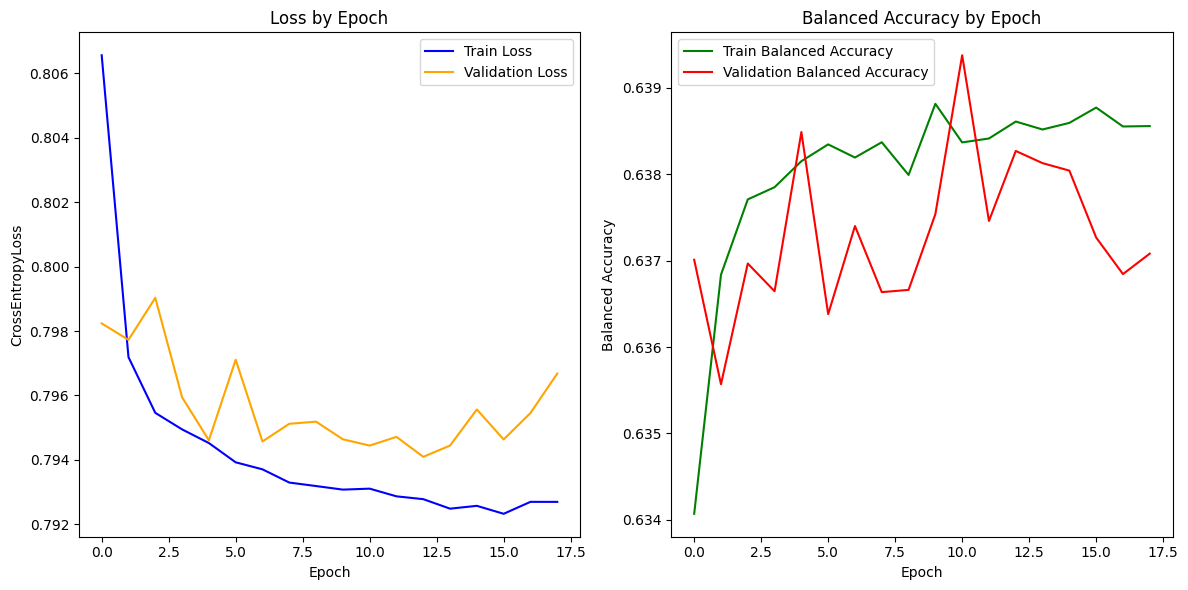

Accuracy: 0.7100
Balanced Accuracy: 0.6377
Precision: 0.7208
Recall: 0.7100
F1-Score: 0.7011

Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.46      0.58     18985
         1.0       0.83      0.82      0.83     53121
         2.0       0.46      0.37      0.41     15803
         3.0       0.59      0.90      0.71     22105

    accuracy                           0.71    110014
   macro avg       0.67      0.64      0.63    110014
weighted avg       0.72      0.71      0.70    110014



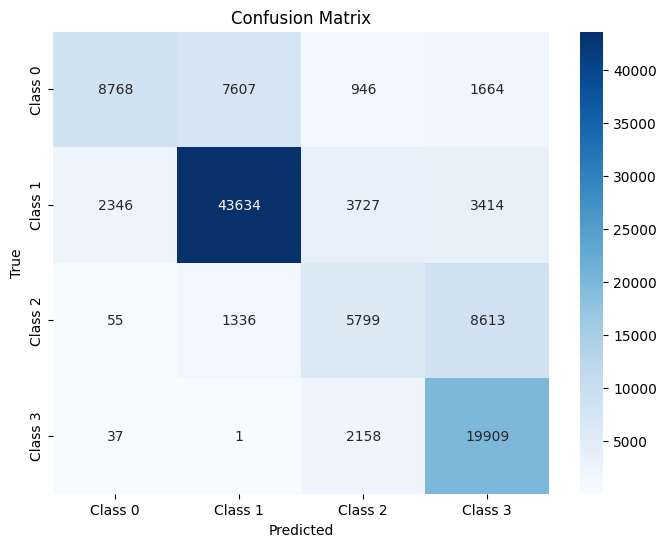

In [62]:
trainer_v3.fit(
    train_dataloader=train_dataloader,
    val_dataloader=test_dataloader,
    epochs=50
)

# Retrieve metrics
train_loss_by_epoch, valid_loss_by_epoch, train_accuracy_by_epoch, valid_accuracy_by_epoch = trainer.get_training_metrics()

# Plot metrics
printTrainLossVsValidLossAndAccuracy(
    train_loss_by_epoch,
    valid_loss_by_epoch,
    train_accuracy_by_epoch,
    valid_accuracy_by_epoch,
)

# Predict on test set
y_true, y_pred = trainer_v3.predict(test_dataloader)

# Evaluate predictions
evaluate_classifier(nnet, y_pred)

Parece comportarse apenas mejor, aunque no vemos mucha diferencia. Predice mejor la clase 2, pero peor las clases 0 y 3, y la precisión balanceada supera apenas la anterior, en un 0,06%.
Por lo pronto mantendremos el primer dataset resultante, no descartando volver a probar este dataset con otra red candidata.

Vamos a intentar un último modelo, aumentando la tasa de aprendizaje, pero ajustandola con un scheduler cada ciertos pasos, para ver si logramos algún mejor resultado.

In [27]:
class NNetWithDropout(torch.nn.Module):

  def __init__(self, input_size, output_size):
    super().__init__()
    self.linear_1 = torch.nn.Linear(input_size, 128, bias=True)
    self.relu_1 = torch.nn.ReLU()
    self.dropout_1 = torch.nn.Dropout(p=0.2)

    self.linear_2 = torch.nn.Linear(128, 64, bias=True)
    self.relu_2 = torch.nn.ReLU()
    self.dropout_2 = torch.nn.Dropout(p=0.2)

    self.output = torch.nn.Linear(64, output_size, bias=True)

  def forward(self, x):
    x = self.linear_1(x)
    x = self.relu_1(x)
    x = self.dropout_1(x)

    x = self.linear_2(x)
    x = self.relu_2(x)
    x = self.dropout_2(x)

    x = self.output(x)
    return x

In [28]:
X = black_sale_data_processed.drop(columns=['Purchase', 'Purchase_Group', 'User_ID', 'Product_ID'])
y = black_sale_data_processed['Purchase_Group']

X_numpy = X.to_numpy(dtype='float')
y_numpy = y.to_numpy(dtype='float')

X_train, X_test, y_train, y_test = train_test_split(X_numpy, y_numpy, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

train_black_sale_ds = BlackSaleDataset(X_train_scaled, y_train)
test_black_sale_ds = BlackSaleDataset(X_test_scaled, y_test)

train_dataloader = DataLoader(train_black_sale_ds, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_black_sale_ds, batch_size=64)

In [35]:
# Crear el modelo
nnet = NNetWithDropout(input_size=X_train.shape[1], output_size=len(np.unique(y_train))).to(device)

# Configurar el optimizador y la función de pérdida
optimizer = optim.Adam(nnet.parameters(), lr=0.01, weight_decay=0.001)

criterion = nn.CrossEntropyLoss(weight=class_weights)

# Scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.2)

In [36]:
trainer_v4 = Trainer(
    model=nnet,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    early_stopper=EarlyStopper(patience=5, mode="min"),
    save_best_model=True,
    best_model_name="nn_v4.pth"
)

In [ ]:
trainer_v4.fit(
    train_dataloader=train_dataloader,
    val_dataloader=test_dataloader,
    epochs=50
)

# Retrieve metrics
train_loss_by_epoch, valid_loss_by_epoch, train_accuracy_by_epoch, valid_accuracy_by_epoch = trainer.get_training_metrics()

# Plot metrics
printTrainLossVsValidLossAndAccuracy(
    train_loss_by_epoch,
    valid_loss_by_epoch,
    train_accuracy_by_epoch,
    valid_accuracy_by_epoch,
)

# Predict on test set
y_true, y_pred = trainer_v4.predict(test_dataloader)

# Evaluate predictions
evaluate_classifier(nnet, y_pred)

Epoch 1/50
Train Loss: 0.8525 | Train Accuracy: 0.6760 | Train Balanced Accuracy: 0.6131
Validation Loss: 0.8324 | Validation Accuracy: 0.6958 | Validation Balanced Accuracy: 0.6239
Saved Best Model
It's learning!
Epoch 2/50
Train Loss: 0.8515 | Train Accuracy: 0.6774 | Train Balanced Accuracy: 0.6130
Validation Loss: 0.8264 | Validation Accuracy: 0.7042 | Validation Balanced Accuracy: 0.6277
Saved Best Model
It's learning!
Epoch 3/50
Train Loss: 0.8514 | Train Accuracy: 0.6774 | Train Balanced Accuracy: 0.6132
Validation Loss: 0.8275 | Validation Accuracy: 0.7046 | Validation Balanced Accuracy: 0.6278
Saved Best Model
It's not learning... patience: 5
Epoch 4/50
Train Loss: 0.8515 | Train Accuracy: 0.6757 | Train Balanced Accuracy: 0.6135
Validation Loss: 0.8314 | Validation Accuracy: 0.7012 | Validation Balanced Accuracy: 0.6231
It's not learning... patience: 4
Epoch 5/50
Train Loss: 0.8526 | Train Accuracy: 0.6761 | Train Balanced Accuracy: 0.6118
Validation Loss: 0.8404 | Validation

## Entrenamiento de Red Neuronal con embedding (d) ##

### Definición de clases para trabajar con embeddings ###

In [106]:
class BlackSaleDatasetWithEmbeddings(Dataset):

  #__init__ guarda el dataset en una variable de clase
  def __init__(self, x, user_idx, product_idx, y):
    self.x = x
    self.user_idx = user_idx
    self.product_idx = product_idx
    self.y = y

  # __len__ define el comportamiento de la función len() sobre el objeto
  def __len__(self):
    return len(self.x)

  # __getitem__ define el comportamiento de los []
  def __getitem__(self, idx):
    return self.x[idx], self.user_idx[idx], self.product_idx[idx], self.y[idx]

In [107]:
class TrainerWithEmbeddings(Trainer):
    def _process_batch(self, x_batch, user_id_batch, product_id_batch, y_batch, train=True):
        x_batch = x_batch.to(self.device).float()
        user_id_batch = user_id_batch.to(self.device).int()
        product_id_batch = product_id_batch.to(self.device).int()
        y_batch = y_batch.to(self.device).long()

        if train:
            self.optimizer.zero_grad()

        nnet_output = self.model(x_batch, user_id_batch, product_id_batch)
        loss = self.criterion(nnet_output, y_batch)

        if train:
            loss.backward()
            self.optimizer.step()

        _, y_batch_hat = torch.max(nnet_output, dim=1)
        return loss.item(), y_batch.cpu().numpy(), y_batch_hat.cpu().numpy()

    def _epoch(self, dataloader, train=True):
        mode = "train" if train else "eval"
        getattr(self.model, mode)()

        epoch_loss = 0
        epoch_y = []
        epoch_y_hat = []

        with torch.set_grad_enabled(train):
            for x_batch, user_id_batch, product_id_batch, y_batch in dataloader:
                loss, y_true, y_pred = self._process_batch(x_batch, user_id_batch, product_id_batch, y_batch, train)
                epoch_loss += loss
                epoch_y.extend(y_true)
                epoch_y_hat.extend(y_pred)

        epoch_loss /= len(dataloader)
        accuracy = accuracy_score(epoch_y, epoch_y_hat)
        balanced_accuracy = balanced_accuracy_score(epoch_y, epoch_y_hat)
        return epoch_loss, accuracy, balanced_accuracy

### Entrenamiendo de las redes neuronales con embeddings ###

Primero veamos a cuantos user_ids y product_ids distintos tenemos que aplicar embedding, ya que lo usaremos luego en nuestra red reuronal:

In [ ]:
user_id = black_sale_data_processed['User_ID']
product_id = black_sale_data_processed['Product_ID']

print(f"Número de usuarios distintos: {len(user_id.unique())}")
print(f"Número de productos distintos: {len(product_id.unique())}")

user_id_to_idx = {value:i for i,value in enumerate(black_sale_data_processed['User_ID'].unique())}
product_id_to_idx = {value:i for i,value in enumerate(black_sale_data_processed['Product_ID'].unique())}

user_idx = np.array([user_id_to_idx[value] for value in user_id])
product_idx = np.array([product_id_to_idx[value] for value in product_id])

idx_to_user_id = {i: value for value, i in user_id_to_idx.items()}

Número de usuarios distintos: 5891
Número de productos distintos: 3631


In [ ]:
X = black_sale_data_processed.drop(columns=['Purchase', 'Purchase_Group', 'User_ID', 'Product_ID'])
y = black_sale_data_processed['Purchase_Group']

X_numpy = X.to_numpy(dtype='float')
y_numpy = y.to_numpy(dtype='float')

X_train, X_test, y_train, y_test, user_idx_train, user_idx_test, product_idx_train, product_idx_test = train_test_split(
    X_numpy, y_numpy, user_idx, product_idx, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

train_black_sale_ds_embeddings = BlackSaleDatasetWithEmbeddings(X_train_scaled, user_idx_train, product_idx_train, y_train)
test_black_sale_ds_embeddings = BlackSaleDatasetWithEmbeddings(X_test_scaled, user_idx_test, product_idx_test, y_test)

train_dataloader_embeddings = DataLoader(train_black_sale_ds_embeddings, batch_size=32, shuffle=True)
test_dataloader_embeddings = DataLoader(test_black_sale_ds_embeddings, batch_size=32)

In [ ]:
class NNetImproveWithEmbeddings(torch.nn.Module):

  def __init__(self, input_size, output_size, user_idx_embeddings_dim, product_idx_embeddings_dim):
    super().__init__()
    self.embeddings_user_id = torch.nn.Embedding(num_embeddings=5891, embedding_dim=user_idx_embeddings_dim)
    self.embeddings_product_id = torch.nn.Embedding(num_embeddings=3631, embedding_dim=product_idx_embeddings_dim)
    self.linear_1 = torch.nn.Linear(input_size + user_idx_embeddings_dim + product_idx_embeddings_dim, 128, bias=True)
    self.relu_1 = torch.nn.ReLU()
    self.dropout_1 = torch.nn.Dropout(p=0.2)

    self.linear_2 = torch.nn.Linear(128, 64, bias=True)
    self.relu_2 = torch.nn.ReLU()
    self.dropout_2 = torch.nn.Dropout(p=0.2)

    self.output = torch.nn.Linear(64, output_size, bias=True)

  def forward(self, x, user_idx, product_idx):
    embeddings_user_id_outputs = self.embeddings_user_id(user_idx)
    embeddings_product_id_outputs = self.embeddings_product_id(product_idx)
    x = torch.cat([x, embeddings_user_id_outputs, embeddings_product_id_outputs], dim=1)
    x = self.linear_1(x)
    x = self.relu_1(x)
    x = self.dropout_1(x)

    x = self.linear_2(x)
    x = self.relu_2(x)
    x = self.dropout_2(x)

    x = self.output(x)
    return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [ ]:
# Crear el modelo
nnet_with_embeddings = NNetImproveWithEmbeddings(
    input_size=X_train.shape[1],
    output_size=len(np.unique(y_train)),
    user_idx_embeddings_dim=12,
    product_idx_embeddings_dim=10
).to(device)
# Configurar la pérdida con los pesos
criterion = nn.CrossEntropyLoss(weight=class_weights)
# Configurar el optimizador y la función de pérdida
optimizer = optim.Adam(nnet_with_embeddings.parameters(), lr=0.001)
# Scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
trainer = TrainerWithEmbeddings(
    model=nnet_with_embeddings,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    early_stopper=EarlyStopper(patience=10, mode="min")
)

Is learning!
 Epoch 0 | Train/Valid loss: 0.787 / 0.737 | Train/Valid accuracy: 0.694 / 0.698 | Train/Valid balanced accuracy: 0.647 / 0.670
Is learning!
 Epoch 1 | Train/Valid loss: 0.721 / 0.702 | Train/Valid accuracy: 0.708 / 0.722 | Train/Valid balanced accuracy: 0.681 / 0.689
Is learning!
 Epoch 2 | Train/Valid loss: 0.693 / 0.689 | Train/Valid accuracy: 0.717 / 0.719 | Train/Valid balanced accuracy: 0.697 / 0.696
Is learning!
 Epoch 3 | Train/Valid loss: 0.680 / 0.682 | Train/Valid accuracy: 0.721 / 0.719 | Train/Valid balanced accuracy: 0.703 / 0.700
Is learning!
 Epoch 4 | Train/Valid loss: 0.671 / 0.680 | Train/Valid accuracy: 0.724 / 0.722 | Train/Valid balanced accuracy: 0.707 / 0.699
Is learning!
 Epoch 5 | Train/Valid loss: 0.666 / 0.677 | Train/Valid accuracy: 0.725 / 0.717 | Train/Valid balanced accuracy: 0.710 / 0.703
Is learning!
 Epoch 6 | Train/Valid loss: 0.661 / 0.676 | Train/Valid accuracy: 0.727 / 0.717 | Train/Valid balanced accuracy: 0.711 / 0.703
Is learning!


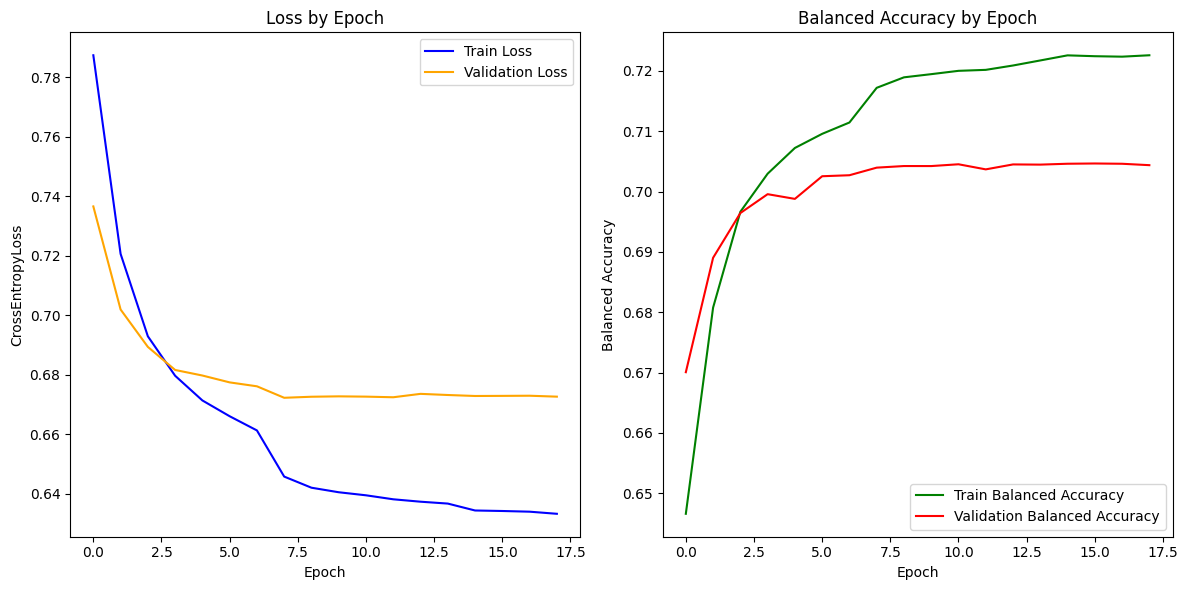

In [ ]:
trained_model_with_embeddings = trainer.train(
    train_dataloader=train_dataloader_embeddings,
    test_dataloader=test_dataloader_embeddings,
    epochs=50
)

In [ ]:
class NNetImproveWithEmbeddings2(torch.nn.Module):

  def __init__(self, input_size, output_size, user_idx_embeddings_dim, product_idx_embeddings_dim):
    super().__init__()
    self.embeddings_user_id = torch.nn.Embedding(num_embeddings=5891, embedding_dim=user_idx_embeddings_dim)
    self.embeddings_product_id = torch.nn.Embedding(num_embeddings=3631, embedding_dim=product_idx_embeddings_dim)
    self.linear_1 = torch.nn.Linear(input_size + user_idx_embeddings_dim + product_idx_embeddings_dim, 64, bias=True)
    self.relu_1 = torch.nn.ReLU()
    self.dropout_1 = torch.nn.Dropout(p=0.5)

    self.linear_2 = torch.nn.Linear(64, 32, bias=True)
    self.relu_2 = torch.nn.ReLU()
    self.dropout_2 = torch.nn.Dropout(p=0.5)

    self.output = torch.nn.Linear(32, output_size, bias=True)

  def forward(self, x, user_idx, product_idx):
    embeddings_user_id_outputs = self.embeddings_user_id(user_idx)
    embeddings_product_id_outputs = self.embeddings_product_id(product_idx)
    x = torch.cat([x, embeddings_user_id_outputs, embeddings_product_id_outputs], dim=1)
    x = self.linear_1(x)
    x = self.relu_1(x)
    x = self.dropout_1(x)

    x = self.linear_2(x)
    x = self.relu_2(x)
    x = self.dropout_2(x)

    x = self.output(x)
    return x

In [ ]:
# Crear el modelo
nnet_with_embeddings = NNetImproveWithEmbeddings2(
    input_size=X_train.shape[1],
    output_size=len(np.unique(y_train)),
    user_idx_embeddings_dim=12,
    product_idx_embeddings_dim=10
).to(device)
# Configurar la pérdida con los pesos
criterion = nn.CrossEntropyLoss(weight=class_weights)
# Configurar el optimizador y la función de pérdida
optimizer = optim.Adam(nnet_with_embeddings.parameters(), lr=0.001)
# Scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

trainer = TrainerWithEmbeddings(
    model=nnet_with_embeddings,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    early_stopper=EarlyStopper(patience=10, mode="min")
)

It's learning!
 Epoch 0 | Train/Valid loss: 0.709 / 0.686 | Train/Valid accuracy: 0.713 / 0.721 | Train/Valid balanced accuracy: 0.692 / 0.695
It's learning!
 Epoch 1 | Train/Valid loss: 0.706 / 0.683 | Train/Valid accuracy: 0.715 / 0.716 | Train/Valid balanced accuracy: 0.695 / 0.698
It's learning!
 Epoch 2 | Train/Valid loss: 0.691 / 0.679 | Train/Valid accuracy: 0.721 / 0.721 | Train/Valid balanced accuracy: 0.702 / 0.702
It's learning!
 Epoch 3 | Train/Valid loss: 0.688 / 0.678 | Train/Valid accuracy: 0.721 / 0.724 | Train/Valid balanced accuracy: 0.704 / 0.702
It's learning!
 Epoch 4 | Train/Valid loss: 0.686 / 0.678 | Train/Valid accuracy: 0.721 / 0.722 | Train/Valid balanced accuracy: 0.704 / 0.702
It's not learning... patience: 10
 Epoch 5 | Train/Valid loss: 0.685 / 0.678 | Train/Valid accuracy: 0.722 / 0.722 | Train/Valid balanced accuracy: 0.705 / 0.702
It's learning!
 Epoch 6 | Train/Valid loss: 0.684 / 0.677 | Train/Valid accuracy: 0.722 / 0.719 | Train/Valid balanced accu

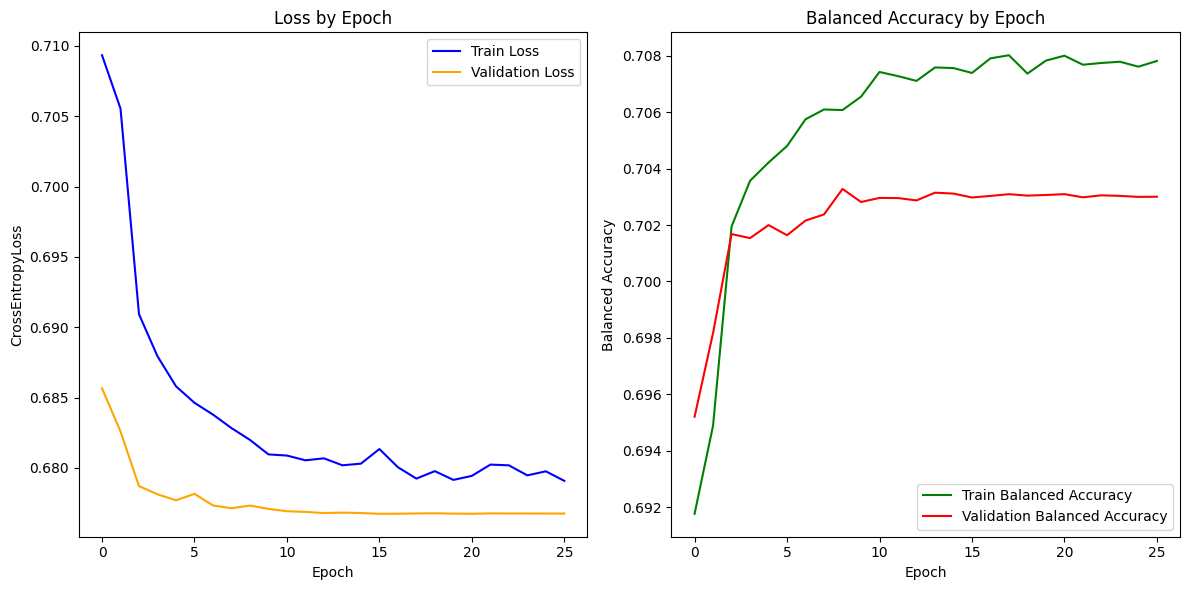

In [ ]:
trained_model_with_embeddings = trainer.train(
    train_dataloader=train_dataloader_embeddings,
    test_dataloader=test_dataloader_embeddings,
    epochs=50
)

In [ ]:
import torch
from torch.nn.functional import normalize

def suggest_similar_users(user_id, user_id_to_idx, n, embedding_layer):
    """
    Sugerir usuarios similares basándose en los embeddings.

    Args:
        user_id (int): ID del usuario objetivo.
        n (int): Número de usuarios similares a sugerir.
        embedding_layer (torch.nn.Embedding): Capa de embedding de usuarios.

    Returns:
        List[int]: Lista de IDs de los usuarios más similares.
    """
    # Obtener el embedding del usuario objetivo
    user_embedding = embedding_layer(torch.tensor([user_id_to_idx[user_id]]).to(device))  # (1, embedding_dim)
    print(f"user_embedding: {user_embedding}")

    # Normalizar el embedding del usuario objetivo
    user_embedding = normalize(user_embedding, p=2, dim=1)  # (1, embedding_dim)
    print(f"user_embedding_normalized: {user_embedding}")

    # Obtener todos los embeddings
    all_user_embeddings = embedding_layer.weight.data  # (num_users, embedding_dim)
    print(f"all_user_embeddings: {all_user_embeddings}")

    # Normalizar todos los embeddings
    all_user_embeddings = normalize(all_user_embeddings, p=2, dim=1)
    print(f"all_user_embeddings_normalized: {all_user_embeddings}")

    # Calcular similitud coseno entre el usuario objetivo y todos los usuarios
    similarities = torch.mm(user_embedding, all_user_embeddings.T).squeeze(0)  # (num_users,)
    print(f"similarities: {similarities}")
    similarities = similarities.squeeze(0)
    print(f"similarities: {similarities}")

    # Obtener los IDs de los usuarios más similares (excluyendo el usuario mismo)
    most_similar = torch.topk(similarities, k=n+1).indices.tolist()  # +1 para excluir el mismo usuario
    most_similar = [idx_to_user_id[idx] for idx in most_similar]
    most_similar = [u_id for u_id in most_similar if u_id != user_id][:n]

    print(f"most_similar: {most_similar}")

    return most_similar

In [ ]:
# Obtener los usuarios similares
user_id = 1001606  # ID del usuario objetivo
n = 5         # Número de usuarios similares a encontrar

similar_users = suggest_similar_users(user_id, user_id_to_idx, n, trained_model_with_embeddings.embeddings_user_id)

print(f"Usuarios similares al usuario {user_id}: {similar_users}")

user_embedding: tensor([[-1.2388,  0.4890, -0.8909,  0.2800, -0.4485, -1.1273, -2.1612, -0.3948,
         -1.6162, -0.6189, -0.6047,  0.6188]], grad_fn=<EmbeddingBackward0>)
user_embedding_normalized: tensor([[-0.3478,  0.1373, -0.2501,  0.0786, -0.1259, -0.3165, -0.6067, -0.1108,
         -0.4537, -0.1737, -0.1698,  0.1737]], grad_fn=<DivBackward0>)
all_user_embeddings: tensor([[-0.5078,  0.6590, -1.2531,  ..., -0.2139, -0.2490,  0.9994],
        [ 0.6942, -0.2226, -1.1428,  ...,  2.3179, -0.7764, -1.2058],
        [ 0.6079, -2.6406, -0.6139,  ..., -0.1815,  0.7495, -0.5737],
        ...,
        [ 2.0443, -1.5458, -0.5501,  ...,  1.0029,  0.3082, -0.1733],
        [-0.3929, -1.0253,  0.0449,  ..., -1.0224, -0.8415,  1.6642],
        [-0.0971, -0.9281,  1.4431,  ..., -0.3609, -1.6660,  1.1010]])
all_user_embeddings_normalized: tensor([[-0.1193,  0.1548, -0.2944,  ..., -0.0503, -0.0585,  0.2348],
        [ 0.1705, -0.0546, -0.2806,  ...,  0.5692, -0.1906, -0.2961],
        [ 0.1594, -0

In [ ]:
# Obtener los usuarios similares
user_id = 1001606  # ID del usuario objetivo
n = 5         # Número de usuarios similares a encontrar

similar_users = suggest_similar_users(user_id, user_id_to_idx, n, trained_model_with_embeddings.embeddings_user_id)

print(f"Usuarios similares al usuario {user_id}: {similar_users}")

user_embedding: tensor([[-0.9399,  0.3537, -1.3847,  0.4591, -0.1315, -1.5515, -2.5288, -0.7720,
         -1.9264, -0.9022, -0.4216,  0.8479]], grad_fn=<EmbeddingBackward0>)
user_embedding_normalized: tensor([[-0.2217,  0.0834, -0.3266,  0.1083, -0.0310, -0.3660, -0.5965, -0.1821,
         -0.4544, -0.2128, -0.0994,  0.2000]], grad_fn=<DivBackward0>)
all_user_embeddings: tensor([[ 0.0296,  0.5662, -1.7112,  ..., -0.4097, -0.0907,  1.2237],
        [ 0.9794, -0.2659, -1.5361,  ...,  2.1731, -0.6074, -0.9187],
        [ 0.6201, -2.8436, -0.8302,  ..., -0.4599,  0.9921, -0.3149],
        ...,
        [ 2.0135, -1.5856, -0.5858,  ...,  0.9198,  0.3549, -0.1079],
        [-0.1996, -1.0392, -0.0961,  ..., -1.0723, -0.8334,  1.7045],
        [ 0.0634, -0.9766,  1.1728,  ..., -0.5119, -1.5368,  1.3096]])
all_user_embeddings_normalized: tensor([[ 0.0065,  0.1243, -0.3756,  ..., -0.0899, -0.0199,  0.2686],
        [ 0.2290, -0.0622, -0.3592,  ...,  0.5082, -0.1420, -0.2148],
        [ 0.1432, -0

In [ ]:
# prompt: quiero las rows del dataset para los user_id 1001606 y 1000330

# Assuming 'black_sale_data' DataFrame is available from the provided code.
user_ids_to_find = [1001606, 1000330]
result_df = black_sale_data[black_sale_data['User_ID'].isin(user_ids_to_find)]
result_df

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
2096,1000330,P00080342,M,55+,7,C,2,0,1,6.0,8.0,19527
2097,1000330,P00174842,M,55+,7,C,2,0,17,NaN,NaN,10366
10442,1001606,P00145042,F,36-45,3,A,4+,0,1,2.0,5.0,19564
10443,1001606,P00146042,F,36-45,3,A,4+,0,1,13.0,15.0,11442
10444,1001606,P00250242,F,36-45,3,A,4+,0,5,NaN,NaN,5323
...,...,...,...,...,...,...,...,...,...,...,...,...
516826,1001606,P00129342,F,36-45,3,A,4+,0,1,5.0,15.0,15559
516827,1001606,P00187342,F,36-45,3,A,4+,0,4,5.0,15.0,2079
516828,1001606,P00347642,F,36-45,3,A,4+,0,1,6.0,NaN,11407
516829,1001606,P00294542,F,36-45,3,A,4+,0,8,NaN,NaN,9909


In [128]:
class TrainerWithEmbeddingsV2():
    def __init__(self, model, optimizer, criterion, device, scheduler=None, early_stopper=None, save_best_model=False):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.early_stopper = early_stopper
        self.save_best_model = save_best_model
        self.best_accuracy = 0
        self.train_loss_by_epoch = []
        self.valid_loss_by_epoch = []
        self.train_accuracy_by_epoch = []
        self.valid_accuracy_by_epoch = []

    def _process_batch(self, x_batch, user_id_batch, product_id_batch, y_batch, train=True):
        x_batch = x_batch.to(self.device).float()
        user_id_batch = user_id_batch.to(self.device).long()  # Use long for embedding indices
        product_id_batch = product_id_batch.to(self.device).long()
        y_batch = y_batch.to(self.device).long()

        if train:
            self.optimizer.zero_grad()

        nnet_output = self.model(x_batch, user_id_batch, product_id_batch)
        loss = self.criterion(nnet_output, y_batch)

        if train:
            loss.backward()
            self.optimizer.step()

        _, y_batch_hat = torch.max(nnet_output, dim=1)
        return loss.item(), y_batch.cpu().numpy(), y_batch_hat.cpu().numpy()

    def _epoch(self, dataloader, train=True):
        mode = "train" if train else "eval"
        getattr(self.model, mode)()

        epoch_loss = 0
        epoch_y = []
        epoch_y_hat = []

        with torch.set_grad_enabled(train):
            for x_batch, user_id_batch, product_id_batch, y_batch in dataloader:
                loss, y_true, y_pred = self._process_batch(x_batch, user_id_batch, product_id_batch, y_batch, train)
                epoch_loss += loss
                epoch_y.extend(y_true)
                epoch_y_hat.extend(y_pred)

        epoch_loss /= len(dataloader)
        accuracy = accuracy_score(epoch_y, epoch_y_hat)
        balanced_accuracy = balanced_accuracy_score(epoch_y, epoch_y_hat)
        return epoch_loss, accuracy, balanced_accuracy

    def fit(self, train_dataloader, val_dataloader=None, epochs=10):
        for epoch in range(1, epochs + 1):
            print(f"Epoch {epoch}/{epochs}")

            # Training
            train_loss, train_accuracy, train_balanced_accuracy = self._epoch(train_dataloader, train=True)
            self.train_loss_by_epoch.append(train_loss)
            self.train_accuracy_by_epoch.append(train_balanced_accuracy)
            print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | Train Balanced Accuracy: {train_balanced_accuracy:.4f}")

            # Validation
            if val_dataloader:
                val_loss, val_accuracy, val_balanced_accuracy = self._epoch(val_dataloader, train=False)
                self.valid_loss_by_epoch.append(val_loss)
                self.valid_accuracy_by_epoch.append(val_balanced_accuracy)
                print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | Validation Balanced Accuracy: {val_balanced_accuracy:.4f}")

                # Save the best model
                if self.save_best_model and val_accuracy > self.best_accuracy:
                    self.best_accuracy = val_accuracy
                    torch.save(self.model.state_dict(), "best_model.pth")
                    print("Saved Best Model")

                # Early stopping
                if self.early_stopper and self.early_stopper.step(val_loss, self.model):
                    print(f"Early stopping triggered at epoch {epoch}")
                    break

            # Update learning rate with the scheduler
            if self.scheduler:
                # Step scheduler
                self.scheduler.step()

    def get_training_metrics(self):
        return self.train_loss_by_epoch, self.valid_loss_by_epoch, self.train_accuracy_by_epoch, self.valid_accuracy_by_epoch

    def predict(self, dataloader):
        self.model.eval()
        all_y_true = []
        all_y_pred = []

        with torch.no_grad():
            for x_batch, user_id_batch, product_id_batch, y_batch in dataloader:
                _, y_true, y_pred = self._process_batch(x_batch, user_id_batch, product_id_batch, y_batch, train=False)
                all_y_true.extend(y_true)
                all_y_pred.extend(y_pred)

        return np.array(all_y_true), np.array(all_y_pred)

In [130]:
# Crear el modelo
nnet_with_embeddings = NNetImproveWithEmbeddings2(
    input_size=X_train.shape[1],
    output_size=len(np.unique(y_train)),
    user_idx_embeddings_dim=12,
    product_idx_embeddings_dim=10
).to(device)
# Configurar la pérdida con los pesos
criterion = nn.CrossEntropyLoss(weight=class_weights)
# Configurar el optimizador y la función de pérdida
optimizer = optim.Adam(nnet_with_embeddings.parameters(), lr=0.001)
# Scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


# Initialize trainer
trainer = TrainerWithEmbeddingsV2(
    model=nnet_with_embeddings,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    early_stopper=EarlyStopper(patience=10, mode="min"),
    save_best_model=True
)

# Train and evaluate
trainer.fit(train_dataloader_embeddings, test_dataloader_embeddings, epochs=50)

# Retrieve metrics
train_loss_by_epoch, valid_loss_by_epoch, train_accuracy_by_epoch, valid_accuracy_by_epoch = trainer.get_training_metrics()

# Plot metrics
printTrainLossVsValidLossAndAccuracy(
    train_loss_by_epoch,
    valid_loss_by_epoch,
    train_accuracy_by_epoch,
    valid_accuracy_by_epoch,
)

# Predict on test set
y_true, y_pred = trainer.predict(test_dataloader_embeddings)

# Evaluate predictions
evaluate_classifier(nnet_with_embeddings, y_pred)

Epoch 1/50
Train Loss: 0.8334 | Train Accuracy: 0.6845 | Train Balanced Accuracy: 0.6270
Validation Loss: 0.7486 | Validation Accuracy: 0.7114 | Validation Balanced Accuracy: 0.6615
Saved Best Model
It's learning!
Epoch 2/50
Train Loss: 0.7630 | Train Accuracy: 0.6991 | Train Balanced Accuracy: 0.6620
Validation Loss: 0.7133 | Validation Accuracy: 0.7227 | Validation Balanced Accuracy: 0.6844
Saved Best Model
It's learning!
Epoch 3/50
Train Loss: 0.7341 | Train Accuracy: 0.7048 | Train Balanced Accuracy: 0.6784
Validation Loss: 0.6970 | Validation Accuracy: 0.7082 | Validation Balanced Accuracy: 0.6909
It's learning!
Epoch 4/50
Train Loss: 0.7215 | Train Accuracy: 0.7087 | Train Balanced Accuracy: 0.6854
Validation Loss: 0.6952 | Validation Accuracy: 0.7301 | Validation Balanced Accuracy: 0.6921
Saved Best Model
It's learning!
Epoch 5/50
Train Loss: 0.7133 | Train Accuracy: 0.7115 | Train Balanced Accuracy: 0.6901
Validation Loss: 0.6869 | Validation Accuracy: 0.7169 | Validation Balan

KeyboardInterrupt: 

Accuracy: 0.6254
Balanced Accuracy: 0.5511
Precision: 0.6475
Recall: 0.6254
F1-Score: 0.6179

Classification Report:
              precision    recall  f1-score   support

         0.0       0.45      0.73      0.56     18985
         1.0       0.74      0.77      0.75     53121
         2.0       0.38      0.26      0.31     15803
         3.0       0.80      0.44      0.57     22105

    accuracy                           0.63    110014
   macro avg       0.59      0.55      0.55    110014
weighted avg       0.65      0.63      0.62    110014



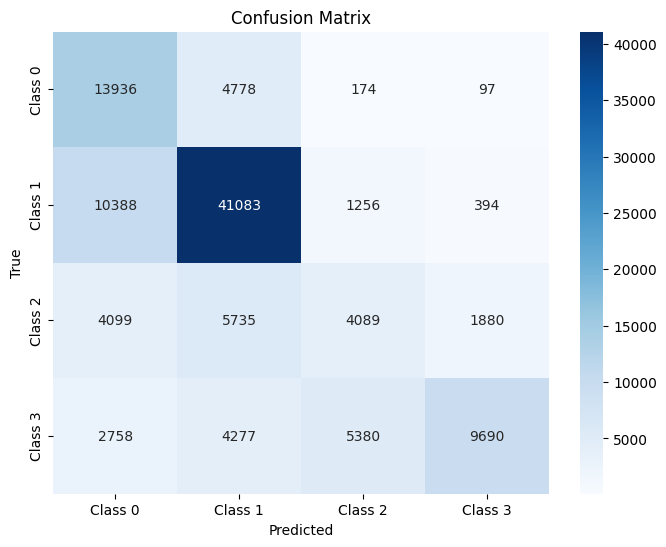

In [111]:
trained_model_with_embeddings.eval()

# Step 2: Calculate predictions
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    user_idx_tensor = torch.tensor(user_idx_test, dtype=torch.long)
    product_idx_tensor = torch.tensor(product_idx_test, dtype=torch.long)

    # Get raw predictions
    y_logits = trained_model_with_embeddings(X_test_tensor, user_idx_tensor, product_idx_tensor)

    # Convert logits to class predictions
    y_pred = torch.argmax(y_logits, dim=1).numpy()

# Step 3: Evaluate using the provided function
evaluate_classifier(trained_model_with_embeddings, y_pred)

In [108]:
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
    embedding_dim_user = trial.suggest_int("embedding_dim_user", 8, 16)
    embedding_dim_product = trial.suggest_int("embedding_dim_product", 6, 14)

    # Define the model
    class NNetImproveWithEmbeddings(torch.nn.Module):
        def __init__(self, input_size, output_size):
            super().__init__()
            self.embeddings_user_id = torch.nn.Embedding(num_embeddings=5891, embedding_dim=embedding_dim_user)
            self.embeddings_product_id = torch.nn.Embedding(num_embeddings=3631, embedding_dim=embedding_dim_product)
            self.linear_1 = torch.nn.Linear(input_size + embedding_dim_user + embedding_dim_product, 128)
            self.relu_1 = torch.nn.ReLU()
            self.dropout_1 = torch.nn.Dropout(p=0.2)
            self.linear_2 = torch.nn.Linear(128, 64)
            self.relu_2 = torch.nn.ReLU()
            self.dropout_2 = torch.nn.Dropout(p=0.2)
            self.output = torch.nn.Linear(64, output_size)

        def forward(self, x, user_idx, product_idx):
            user_embedding = self.embeddings_user_id(user_idx)
            product_embedding = self.embeddings_product_id(product_idx)
            x = torch.cat([x, user_embedding, product_embedding], dim=1)
            x = self.relu_1(self.linear_1(x))
            x = self.dropout_1(x)
            x = self.relu_2(self.linear_2(x))
            x = self.dropout_2(x)
            return self.output(x)

    # Load Data (replace with actual data loading)
    train_dataloader = DataLoader(TensorDataset(torch.randn(1000, 10), torch.randint(0, 5891, (1000,)), torch.randint(0, 3631, (1000,)), torch.randn(1000, 1)), batch_size=32)
    test_dataloader = DataLoader(TensorDataset(torch.randn(200, 10), torch.randint(0, 5891, (200,)), torch.randint(0, 3631, (200,)), torch.randn(200, 1)), batch_size=32)

    model = NNetImproveWithEmbeddings(input_size=10, output_size=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()

    # Training loop
    for epoch in range(10):  # Use more epochs for real tuning
        model.train()
        for x_batch, user_idx, product_idx, y_batch in train_dataloader:
            optimizer.zero_grad()
            y_pred = model(x_batch, user_idx, product_idx)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, user_idx, product_idx, y_batch in test_dataloader:
            y_pred = model(x_batch, user_idx, product_idx)
            val_loss += criterion(y_pred, y_batch).item()
    val_loss /= len(test_dataloader)

    return val_loss


In [ ]:
study = optuna.create_study(direction="minimize")  # Minimize validation loss
study.optimize(objective, n_trials=50)  # Perform 50 trials

# Best hyperparameters
print("Best hyperparameters:", study.best_params)

In [ ]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

### Usando feature engineering alternative

In [ ]:
user_id = black_sale_data_processed_alternative['User_ID']
product_id = black_sale_data_processed_alternative['Product_ID']

In [ ]:
user_id_to_idx = {value:i for i,value in enumerate(black_sale_data_processed_alternative['User_ID'].unique())}
product_id_to_idx = {value:i for i,value in enumerate(black_sale_data_processed_alternative['Product_ID'].unique())}

In [ ]:
user_idx = np.array([user_id_to_idx[value] for value in user_id])
product_idx = np.array([product_id_to_idx[value] for value in product_id])

In [ ]:
X = black_sale_data_processed_alternative.drop(columns=['Purchase', 'Purchase_Group', 'User_ID', 'Product_ID'])
y = black_sale_data_processed_alternative['Purchase_Group']
X_numpy = X.to_numpy(dtype='float')
y_numpy = y.to_numpy(dtype='float')
X_train, X_test, y_train, y_test, user_idx_train, user_idx_test, product_idx_train, product_idx_test = train_test_split(
    X_numpy, y_numpy, user_idx, product_idx, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Parte 2.a

Implemente una arquitectura de red neuronal basada en CNN para identificar del dataset fashion MNIST las 10 clases del mismo. Sobre dicho modelo, realize una exploración de 5 variantes distintas (que se desprenden del modelo propuesto) variando alguno (o varios) de los siguientes hiperparámetros:
- numero de capas.
- numero de kernels.
- tamaño de kernels.


Evalue la evolución de la función de perdida y la accuracy (para train y test) para cada modelo en una gráfica con las curvas de los 5 modelos propuestos. Compare también el tiempo de entrenamiento y peso (tamaño) de cada modelo. Aplique técnicas de regularización para evitar overfitting. Elija el modelo que considera mejor y justifique.
Entregables:
 - Grafica comparativa de función de perdida vs epochs para los 5 modelos.
 - Grafica comparativa de función de accuracy vs epochs para los 5 modelos.
 - Tabla comparativa (o grafico de barras) del tiempo de entrenamiento y pesos de cada modelo.
 - Justificación del modelo elegio (qué consideró para elegir el modelo y bajo qué criterio).



In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
# Download train data from open datasets.
train_data= datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)

# Download test data from open datsets.
test_data=datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)


In [ ]:
import matplotlib.pyplot as plt

labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

# Parte 2.b

Empleando el modelo entrenado y elegido por Ud. en el punto anterior **(NO USAR RESNET U OTRO MODELO DISPONIBLE, TIENE QUE USAR EL QUE UD DESARROLLÓ)**, realice transfer learning para procesar las imágenes del dataset MNIST (los números) **e identificar los números mayores o menores a 4,5**.
Para el entrenamiento emplee solamente 20.000 muestras del set de entrenamiento y valide con el set de testeo. Al reducir el train set, mantenga equilibrada la distribución de las clases.

Elija la estrategia de transfer learning acorde a los visto en la teoría y justifique su elección.

Compare las curvas de entrenamiento y accurracy empleando transfer learning o usando la arquitectura elejida en el punto anterior pero entrenando desde cero.
Entregables:
- Estrategia elegida y su justificación.
- Grafica comparativa de función de perdida vs epochs para el modelo con transfer learning y sin transfer learning.
- Grafica comparativa de función de accuracy vs epochs para el modelo con transfer learning y sin transfer learning.
- Comentarios sobre las curvas graficadas.
